
# CHIHIRO

## Table of Contents

1. [**Introduction and Summary**](#1-introduction--summary)
2. [**Data Loading**](#2-data-loading)
   - 2.1 Journal Data
   - 2.2 Spotify Streaming History
3. [**Data Preparation**](#3-data-preparation)
   - [3.1 OCR Processing](#31-ocr-processing)
   - [3.2 Cleaning](#32-cleaning)
   - [3.3 Exploratory Data Analysis](#33-exploratory-data-analysis)
   - [3.4 Triplet Creation for Similarity Learning](#34-triplet-creation-for-similarity-learning)
4. [**Model Selection and Theory**](#4-model-selection--theory)
   - [4.1 TF-IDF](#41-tf-idf)
   - [4.2 SBERT](#42-sbert)
   - [4.3 Variational Autoencoder (VAE)](#43-variational-autoencoder-vae)
     - 4.3.1 Why Add a VAE and What is it?
     - 4.3.2 Mathematical Framework
5. [**Training Setup**](#5-training-setup)
6. [**Model Evaluation**](#6-model-evaluation)
   - [6.1 Metrics](#61-metrics)
     - 6.1.1 Metric 1: Triplet Accuracy
     - 6.1.2 Metric 2: Embedding Separation
     - 6.1.3 Metric 3: Mean Reciprocal Rank (MRR)
   - [6.2 Comparative Analysis](#6-2-comparative-analysis)
7. [**Interpretability Analysis (LIME)**](#7-interpretability-analysis)
   - [7.1 Mathematical Framework](#71-mathematical-framework)
   - [7.2 Explaining Specific Recommendations](#72-explaining-specific-recommendations)
     - 7.2.1 Query 1
     - 7.2.2 Query 2
     - 7.2.3 Query 3
     - 7.2.4 Opinions
   - [7.3 Real World Results](#73-real-world-results)
8. [**Results and Visualization**](#8-results--visualization-8-results)
9. [**Executive Summary**](#9-executive-summary-9-summary)
10. [**References**](#10-references-10-references)

## 1. Introduction & Summary

In a world full of stoners and alcoholics, my drug of choice is music. This iteration builds upon my first assignment, where I developed a nostalgia-driven music recommendation system called "chihiro." Music basically governs my life; I will listen to the same song over and over again over the course of an entire day or week or month, and then rarely touch it again. As a result, when I play a song from an "era" of mine, it brings me back the heaviest nostalgia. It is the way I remember places, people, food, and experiences.

#### Research Question
Can we predict songs that maximize nostalgia based on semantic similarity between current mood (text input) and past journal entries associated with listening patterns?

#### What's New in v2.0
In Assignment 1, I fine-tuned a single Sentence-BERT model using triplet loss to learn embeddings of my journal entries. The model achieved 51.43% triplet accuracy with an embedding separation of only 0.0106, indicating it struggled to distinguish between songs from different eras. While the model could generate decent nostalgia recommendations, the metrics suggested it was largely relying on pretrained BERT's semantic understanding rather than learning task-specific patterns.

For Assignment 2, I make several key improvements:

**1 TF-IDF Baseline:** I introduced this model as a baseline as in my first assignment my SBERT was working quite terribly, so this helps determine if I really needed Deep Learning.

**2 Improved SBERT Accuracy:** From 55 to 80 by decreasing batch size and training for more epochs. 

**3 Variational Autoencoder (VAE):**
I introduce a second model that learns a continuous latent space of "mood embeddings" using a Variational Autoencoder (VAE) it starts by taking the SBERT embeddings as input and then learns to encode them into a lower-dimensional latent space with a probabilistic structure (mean and variance parameters)... IDK if these will be similar embeddings.

**5 LIME Interpretability:**
I implement Local Interpretable Model-agnostic Explanations to understand which words drive song recommendations. This validates whether my models learned meaningful patterns (e.g., "dumplings" → Taiwan era) versus spurious correlations.

**6 Better Evaluation Metrics:**
Beyond triplet accuracy, I compute Mean Reciprocal Rank (MRR) and analyze embedding distributions to understand recommendation quality at a ranking level, not just binary classification.

**7 Explanations + Organization:**
My explanations are more technical covering more Math topics, they are also better organized and less all over the place. 

#### Why This Matters
Unlike traditional recommendation systems that focus on audio features (e.g., Spotify's content-based filtering) or collaborative filtering (e.g., "users who liked X also liked Y"), my system uses contextual life experiences as the recommendation signal. This is fundamentally a retrieval problem where:

Query: My current mood (text input)
Corpus: My past emotional states (journal entries)
Index: Songs I was listening to during each emotional state

The goal is not to recommend popular songs or sonically similar songs, but to recommend songs that transport me back to specific moments in time. This requires learning associations between semantic content (what I wrote about) and temporal-emotional context (what I was feeling when I repeatedly played a song).

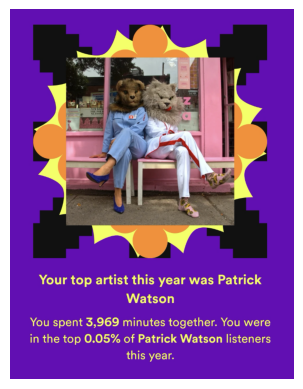

In [74]:
#image display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('../images/img0.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [1]:
# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import os
import warnings
warnings.filterwarnings('ignore')

# Core data processing
import numpy as np
import pandas as pd
import json
import re
import io
import base64
from datetime import datetime
from pathlib import Path
from itertools import combinations
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from pillow_heif import register_heif_opener

# Machine Learning - Core
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

# Machine Learning - Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

# NLP & Transformers
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.evaluation import TripletEvaluator
from datasets import DatasetDict, Dataset as HFDataset

# Interpretability
from lime.lime_text import LimeTextExplainer

# APIs
from openai import OpenAI
from google.cloud import vision

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_ENABLED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Hard-disable MPS so everything runs on CPU
if hasattr(torch.backends, "mps"):
    try:
        torch.backends.mps.is_available = lambda: False
        torch.backends.mps.is_built = lambda: False
        print("⚠️ Forcing torch to ignore MPS; using CPU only.")
    except Exception as e:
        print(f"⚠️ Could not monkeypatch MPS backend: {e}")

print("✅ All libraries imported successfully")


⚠️ Forcing torch to ignore MPS; using CPU only.
✅ All libraries imported successfully


## 2. Data Loading

I collect data from two sources:

### 2.1 Journal Data

Format: 309 HEIC images of handwritten journal entries
Source: 5 physical journals spanning March 2024 - July 2025
Organization: Stored in folders journal1/, journal2/, etc.
Content: Daily reflections about experiences, people, places, emotions

### 2.2 Spotify Streaming History

Format: JSON files from Spotify's "Download Your Data" feature
Records: 32,278 individual song plays
Timespan: August 15, 2023 - July 7, 2025
Unique songs: 4,325 tracks
Fields: Timestamp, track name, artist, album, play duration, IP address (dropped for privacy)

The journals provide the semantic context of my life during specific time periods. The Spotify data provides temporal listening patterns. By combining them, I can learn: "When I was writing about X, Y, and Z, I was listening to Song S." Then, when I write about similar topics in the future, the model should recommend Song S to maximize nostalgia.

In [2]:
def load_heic_images():
    """Load HEIC journal images from organized folder structure"""
    data = []
    for journal_folder in sorted(Path('../data/journals_heic/').iterdir()):
        if journal_folder.is_dir():
            for img_path in sorted(journal_folder.glob('*.HEIC')) + sorted(journal_folder.glob('*.heic')):
                journal_match = re.search(r'journal(\d+)', journal_folder.name)
                data.append({
                    'journal': int(journal_match.group(1)) if journal_match else 1,
                    'heic_path': str(img_path),
                    'filename': img_path.name
                })
    return pd.DataFrame(data).reset_index(drop=True)

def load_spotify():
    """Load and preprocess Spotify streaming history"""
    streams = []
    for filepath in sorted(Path('../data/streaming/').glob('*.json')):
        with open(filepath, 'r') as f:
            streams.extend(json.load(f))
    
    df = pd.DataFrame(streams)
    df['ts'] = pd.to_datetime(df['ts'])
    df['date'] = df['ts'].dt.date
    return df.drop(columns=['ip_addr'], errors='ignore')

# Load data
images_df = load_heic_images()
spotify_df = load_spotify()

print(f"✅ Loaded {len(images_df)} images, {len(spotify_df):,} Spotify streams")
print(f"   Date range: {spotify_df['date'].min()} to {spotify_df['date'].max()}")
print(f"   Unique songs: {spotify_df['master_metadata_track_name'].nunique():,}")


✅ Loaded 309 images, 32,278 Spotify streams
   Date range: 2023-08-15 to 2025-07-07
   Unique songs: 4,325


## 3. Data Preparation 

### 3.1 OCR Processing 

To understand the semantic meaning between my music listening patterns and my journal entries, I first needed to convert images of my handwritten journals into text that machine learning models can process. Hypothetically, I could build my own OCR (Optical Character Recognition) model; however, this would be too steep of a learning curve and would go beyond the scope of this assignment as it does not align with my #purpose. A custom-built OCR model would likely have significantly lower text detection accuracy, which would directly harm my end goal of linking semantic meaning to music listening patterns.

#### Why GPT-4o Vision Over Google Vision OCR?

Originally, I used Google Vision's OCR through the API, which involves Deep Learning Models such as a CNN to determine text and text regions and LSTMs to enhance character prediction sequences. However, I found that the accuracy was pretty low. I came up with the idea of using the OpenAI API 4o model, which essentially works by uploading a picture of my journal with a text prompt asking it to transcribe it to ChatGPT. I found that this worked way better — see results below!

#### Why GPT-4o Works Better

GPT-4o uses a **multimodal transformer architecture** that represents state-of-the-art OCR + language understanding. Unlike traditional OCR that focuses purely on visual character recognition GPT-4o can: **“See” the image** process visual information through vision encoders, and **Understand meaning** use contextual understanding from its language model training, furthermoer it can **Predict from context** which accurately recover words despite messy handwriting by inferring the most likely word from surrounding text.

For example, if my handwriting makes “dumplings” look ambiguous, GPT-4o can infer from context (mentions of food, Taiwan, restaurants) what the word should be instead of just purely trying to fit a bunch of kernals like the OCR.

#### Prompt Engineering for Better Results

I applied prompt engineering techniques from class to improve GPT-4o’s performance. I provided the model with:

- **Clear system role**: “You are a helpful writer's assistant.”
- **Specific instructions**: Transcribe word-by-word, with no additional commentary.
- **Custom vocabulary**: Names of my friends (Hakkei, Rayyan, Arina, Fabian, Shin, etc.).
- **Common phrases I use**: “meow”, “blya”, “questionable”, “gulp”.

#### Handling API Failures with Google Vision Backup

I still included Google Vision OCR in this part of the preprocessing pipeline, as I found that OpenAI would give me API errors when some of my journal entries included information that was misinterpreted as dangerous or inappropriate by OpenAI (e.g., I watched a violent theater show, and it violated OpenAI's guidelines).

#### Date Extraction

After transcribing each journal entry, I use GPT-4o again to extract dates. I prompt the model to output dates in **DDMMYYYY** format (e.g., “March 7 2024” → “07032024”) and return **“unknown”** if no date is found. This two-step process (transcription, then date extraction) produces clean, structured date metadata for the next stages of the pipeline.

Quick note: I did not include the API code here, as I already have them loaded from last time in the same directory so I just directly loaded them in here.

In [3]:
register_heif_opener()

def convert_to_png(heic_df):
    """Convert HEIC images to PNG format for API compatibility"""
    png_images = []
    for idx, row in heic_df.iterrows():
        img = Image.open(row['heic_path'])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        png_images.append(img)
    
    heic_df['png_image'] = png_images
    heic_df['entry'] = range(1, len(heic_df) + 1)
    return heic_df

images_df = convert_to_png(images_df)
print(f"✅ Converted {len(images_df)} images to PNG")

# Load pre-processed data (OCR is expensive, so I cached it)
images_df_subset = pd.read_csv('../processed_journal_data.csv')
print(f"✅ Loaded {len(images_df_subset)} processed journal entries")
print(f"   Success rate: {(images_df_subset['text'] != '').sum()}/{len(images_df_subset)} transcribed")
print(f"   Date extraction: {(images_df_subset['date_str'] != 'unknown').sum()}/{len(images_df_subset)} dated")


✅ Converted 309 images to PNG
✅ Loaded 285 processed journal entries
   Success rate: 285/285 transcribed
   Date extraction: 281/285 dated


In [ ]:
# load openai api key from file
with open('.openai_key', 'r') as f:
    OPENAI_API_KEY = f.read().strip()

openai_client = OpenAI(api_key=OPENAI_API_KEY, timeout=60.0) # setup client with timeout

def transcribe_openai(pil_image):
    buffer = io.BytesIO() # convert image to bytes for api
    pil_image.save(buffer, format='PNG')
    base64_img = base64.b64encode(buffer.getvalue()).decode('utf-8')
    
    response = openai_client.chat.completions.create( # send image to gpt4o for transcription
        model="gpt-4o",
        messages=[{
            "role": "system",
            "content": "You are a helpful writer's assistant. Your mission is to transcribe the user's handwritten journal entries into text output, word by word. Do not add any other text except for what is written in the journal or formatting. Some names of my friends so that you can properly transcribe them: hakkei, rayyan, arina, fabian, fabi, kathi, ani, enya, ransith, ahitagni, omar, amit, camilla, adela, shin, shinnosuke, minnow. Common phrases: meow, blya, questionable, gulp."
        }, {
            "role": "user",
            "content": [
                {"type": "text", "text": "Transcribe this journal:"},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_img}", "detail": "auto"}}
            ]
        }],
        max_tokens=1000
    )
    return response.choices[0].message.content

def extract_date(text):
    response = openai_client.chat.completions.create( # ask gpt to extract the date from text
        model="gpt-4o",
        messages=[{
            "role": "system",
            "content": "Extract date as DDMMYYYY (e.g. March 7 2024 → 07032024). Output 'unknown' if no date."
        }, {
            "role": "user",
            "content": text
        }]
    )
    return response.choices[0].message.content.strip()

def process_single_entry(idx, row, total_count):
    try:
        text = transcribe_openai(row['png_image']) # get text from image
    except Exception as e:
        text = "" # if it fails just use empty string
    date_str = extract_date(text) if text else "unknown" # try to get date from text
    return idx, text, date_str

def process_ocr(images_df, max_workers=5, save_interval=20):
    from concurrent.futures import ThreadPoolExecutor, as_completed
    import pickle
    
    checkpoint_file = 'ocr_checkpoint.pkl'
    results = pickle.load(open(checkpoint_file, 'rb')) if os.path.exists(checkpoint_file) else {} # load prevous results if they exist
    
    total_count = len(images_df)
    tasks = [(idx, row, total_count) for idx, row in images_df.iterrows() if idx not in results] # only process images we havent done yet
    
    if tasks:
        completed = 0
        with ThreadPoolExecutor(max_workers=max_workers) as executor: # process multiple images at same time
            future_to_idx = {executor.submit(process_single_entry, idx, row, total_count): idx for idx, row, total_count in tasks}
            
            for future in as_completed(future_to_idx):
                try:
                    idx, text, date_str = future.result()
                    results[idx] = (text, date_str)
                    completed += 1
                    if completed % save_interval == 0: # save every 20 images incase it crashes
                        pickle.dump(results, open(checkpoint_file, 'wb'))
                except Exception as e:
                    results[future_to_idx[future]] = ("", "unknown") # if image fails just mark as empty
        
        pickle.dump(results, open(checkpoint_file, 'wb')) # final save
    
    sorted_results = [results[idx] for idx in sorted(results.keys())] # put results back in order
    images_df['text'] = [text for text, _ in sorted_results]
    images_df['date_str'] = [date_str for _, date_str in sorted_results]
    return images_df

if images_df_subset is None: # run ocr if not alredy loaded
    images_df_subset = images_df.head(308).copy()
    images_df_subset = process_ocr(images_df_subset, max_workers=5, save_interval=20)
else:
    print(f"skipping ocr - using loaded data") # i saved it as a csv file as openai is costly...

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/maradumitru/chihiro/google-vision-key.json" # set path for google api key

def transcribe_google(pil_image):
    vision_client = vision.ImageAnnotatorClient() # setup google vision client
    buffer = io.BytesIO() # convert image to bytes
    pil_image.save(buffer, format='PNG')
    image = vision.Image(content=buffer.getvalue()) # create vision image object
    response = vision_client.document_text_detection(image=image, image_context=vision.ImageContext(language_hints=["en-t-i0-handwrit"])) # tell it to expect handwritting
    return response.full_text_annotation.text if response.full_text_annotation else "" # return text or empty string

def is_failed_entry(text):
    if not text or text == '': # check if theres no text at all
        return True
    
    text_lower = text.lower().strip() # lowercase for easier comparision
    word_count = len(text.split())
    
    if word_count < 20: # check if openai refused to transcribe it (refusals are usualy short)
        refusal_starts = [ # common refusal patterns that 4o uses
            "i'm sorry, i can't transcribe",
            "i'm sorry, i can't assist",
            "i cannot transcribe",
            "i'm unable to transcribe",
            "i can't transcribe the text"
        ]
        if any(text_lower.startswith(pattern) for pattern in refusal_starts): # see if text starts with any refusal
            return True
    
    return False # text is probly fine

failed_mask = images_df_subset['text'].apply(is_failed_entry) # apply failure check to all entries
failed_indices = images_df_subset[failed_mask].index # get indices of entries that failed
print(f"found {len(failed_indices)} failed openai entries")

if len(failed_indices) > 0: # if there are some failures, use google vision as backup
    print(f"retrying with google vision...")
    
    for idx in failed_indices: # retry failed entries with google vision
        print(f"  entry {idx + 1}...")
        try:
            text = transcribe_google(images_df_subset.loc[idx, 'png_image']) # try google vision instead
            if text: # if we actualy got some text back
                date_str = extract_date(text) # get date from the new text
                images_df_subset.loc[idx, 'text'] = text # update dataframe with new text
                images_df_subset.loc[idx, 'date_str'] = date_str # update date too
                print(f"  success for entry {idx + 1}")
            else:
                print(f"  empty text for entry {idx + 1}") # google also failed lol... although this did not happen
        except Exception as e:
            print(f"  failed for entry {idx + 1}: {e}") 
    
    print(f"\n✅ google vision done")
    successful_entries = ~images_df_subset['text'].apply(is_failed_entry) 
    print(f"   recovered {successful_entries.sum()}/{len(images_df_subset)} entries")
else:
    print("✅ all openai entries ok") 

# Save processed data to CSV
PROCESSED_DATA_CSV = 'processed_journal_data.csv'

# Drop image column for CSV (can't save images to CSV)
csv_df = images_df_subset.drop(columns=['png_image', 'heic_path'], errors='ignore')

csv_df.to_csv(PROCESSED_DATA_CSV, index=False)

print(f"✅ saved to {PROCESSED_DATA_CSV}")
print(f"\nsaved {len(csv_df)} entries:")
print(f"   - {(csv_df['text'] != '').sum()} with transcribed text")
print(f"   - {(csv_df['date_str'] != 'unknown').sum()} with extracted dates")



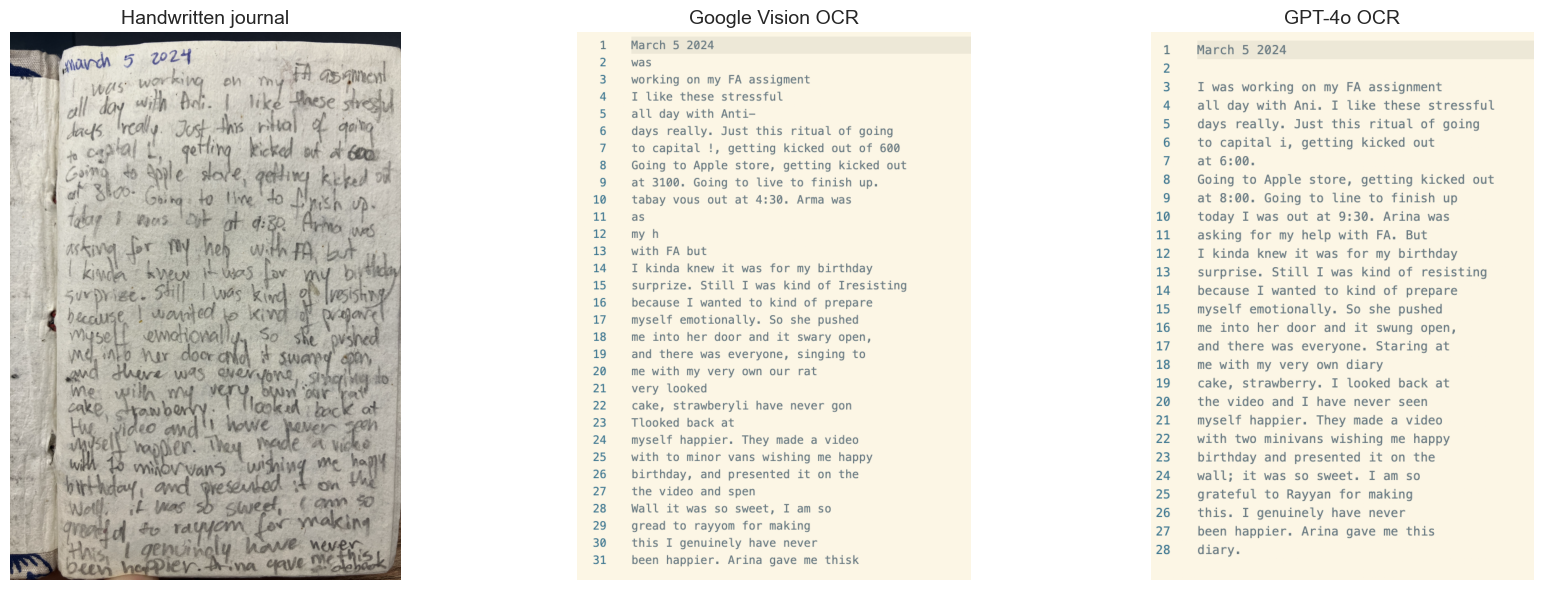

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Note the "../" to go up out of assignment2/
img_journal = mpimg.imread('../images/img1.png')   # handwritten
img_google  = mpimg.imread('../images/img2.png')   # Google Vision
img_openai  = mpimg.imread('../images/img3.png')   # GPT-4o

axes[0].imshow(img_journal)
axes[0].set_title('Handwritten journal', fontsize=14)
axes[0].axis('off')

axes[1].imshow(img_google)
axes[1].set_title('Google Vision OCR', fontsize=14)
axes[1].axis('off')

axes[2].imshow(img_openai)
axes[2].set_title('GPT-4o OCR', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

### 3.2 Cleaning

After transcribing my journals, I performed several data preparation steps to create a dataset suitable for my actual models. 

#### Manual Cleaning

I manually cleaned my `processed_journal_data.csv` file in the following ways:

1. **Date correction**: I corrected a lot of the dates, as sometimes I write journal entries on the same page, sometimes I forget to add the journal entry date, and a lot of the time OpenAI transcribed the date wrong.
2. **Name correction**: I corrected a few names that I found misspelled.
3. **Prompt artifacts**: There were a couple of cases where my prompting failed me, and OpenAI added some extra text like “Sure, here is your transcribed document.”
4. **OCR failures**: I corrected some of the Google Vision OCR misinterpretations.
5. **Data quality**: I deleted some journal entries that were beyond salvation, as the Google Vision OCR failed at transcribing anything even remotely close to the original text. There were only three instances of this.
6. **Privacy**: I cleaned one particularly vulnerable journal entry, as I did not wish to include it.

#### Feature Engineering: Songs as Features of Temporal-Emotional States

The key insight in my data preparation is that **songs are features of temporal-emotional states**, not the other way around. I want to capture the “mood” or “era” associated with each song by aggregating all the journal entries from days when I listened to that song heavily.

**Feature engineering outline:**

1. **Aggregate journal text by date**: Combine all journal text written on the same day into a single entry.
2. **Count song plays per date**: For each date, count how many times I played each song.
3. **Filter threshold**: Keep only songs I played **≥3 times** in a day (filters out accidental plays or songs I skipped).
4. **Create date–song–journal triplets**: Each row represents “On date X, I listened to song Y (N times) while writing about Z.”

This creates a **many-to-many mapping** where for one journal entry I can identify all the songs that I was obsessed with on that one day, as well as identify the journal entries that correlate to one song and so these days ALL these days are part of a songs "era."

#### Text Normalization

I decided to normalize all journal text by:

1. **Lowercasing**: “Hello” and “hello” are treated identically.
2. **Removing special characters**: Strip brackets, backslashes, and other symbols that don’t add semantic meaning.
3. **Normalizing whitespace**: Replace multiple spaces and newlines with single spaces.
4. **Stripping whitespace**: Remove leading and trailing spaces.

This normalization is important because capitalizations at least in my journaling does not affect the scemantic meaning, I mean maybe you can argue that "what" and "WHAT" are different, but that is a limitation. If words were treated differently based on capitalization, the model would need to learn separate representations for each variant and then it would unnecessarily expand the vocabulary and make it harder to learn good embeddings. Because of my small training set its better to simplify.

So in the end I have **486** date–song pairs from **100** unique dates with **324** unique songs in the dataset, and an average of **6.60 plays** per song–date pair. Which basically confirms that I really do obsessively replay songs forming this nostalgic "era" of mine.

In [4]:
def parse_date(s):
    """Convert DDMMYYYY string to datetime.date object"""
    if s == 'unknown' or pd.isna(s):
        return None
    try:
        return datetime(int(s[4:]), int(s[2:4]), int(s[:2])).date()
    except:
        return None

# Process journal data
journal_df = pd.read_csv('../processed_journal_data.csv')
journal_df['date'] = journal_df['date_str'].apply(parse_date)
journal_df = journal_df[journal_df['date'].notna() & (journal_df['text'] != '')]

# Aggregate journal entries by date
journal_by_date = journal_df.groupby('date')['text'].apply(' '.join).reset_index()

# Create song identifiers
spotify_df['song'] = (
    spotify_df['master_metadata_track_name'].fillna('Unknown') + ' - ' + 
    spotify_df['master_metadata_album_artist_name'].fillna('Unknown')
)

# Combine datasets
combined_data = (
    spotify_df.groupby(['date', 'song'])
    .size()
    .reset_index(name='play_count')
    .merge(journal_by_date.rename(columns={'text': 'journal_text'}), on='date', how='inner')
    [lambda df: df['play_count'] >= 3]  # Filter threshold
    .reset_index(drop=True)
)

# Text cleaning
combined_data['journal_text_cleaned'] = (
    combined_data['journal_text']
    .str.lower()
    .str.replace(r'[|\\\[\]{}^]', '', regex=True)
    .str.replace(r'[^a-z0-9\s.,!\'\?\-]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

print(f"✅ Created {len(combined_data)} date-song pairs from {combined_data['date'].nunique()} unique dates")
print(f"   Unique songs in dataset: {combined_data['song'].nunique()}")
print(f"   Average plays per song-date pair: {combined_data['play_count'].mean():.2f}")


✅ Created 486 date-song pairs from 100 unique dates
   Unique songs in dataset: 324
   Average plays per song-date pair: 6.60


### 3.3 Exploratory Data Analysis

I wanted to understand both my listening history and my journals.

#### 3.3.1 Listening Patterns Over Time

For each song played on a given day, I listen to it on average over six times. I wanted to plot my top 10 and 20 listened-to songs and then see how my streaming for those songs varies throughout the year that I journaled.

Interestingly, this data accurately captures my intuitive listening history. See the Top 10 figure. My two favorite songs of all time are *Hell N Back* and *Je Te Laisserai Des Mots*. You can see that instead of addictive spikes, they show long- term patterns. However, for other songs, for instance *Moni*, there is a sharp spike over the course of a couple of weeks, and then it is never played again. Moni shows that I started liking the song and progressively liked it more and more, and then eventually stopped. While, for the song *Kickback*, I started listening to it a lot and then slowly listened less and less until I forgot about it. A song like *Ylang-Ylang* shows how I started listening to it at the end of summer, and over the course of two months I continued to listen to it increasingly, until I finally stopped.

So when I am writing about dumplings, or claw machines, or other things that I did in Taiwan over this "*Ylang-Ylang*" era, I would like it to accurately predict *Ylang-Ylang* or the other songs like *Moni* that I listened to during this time.

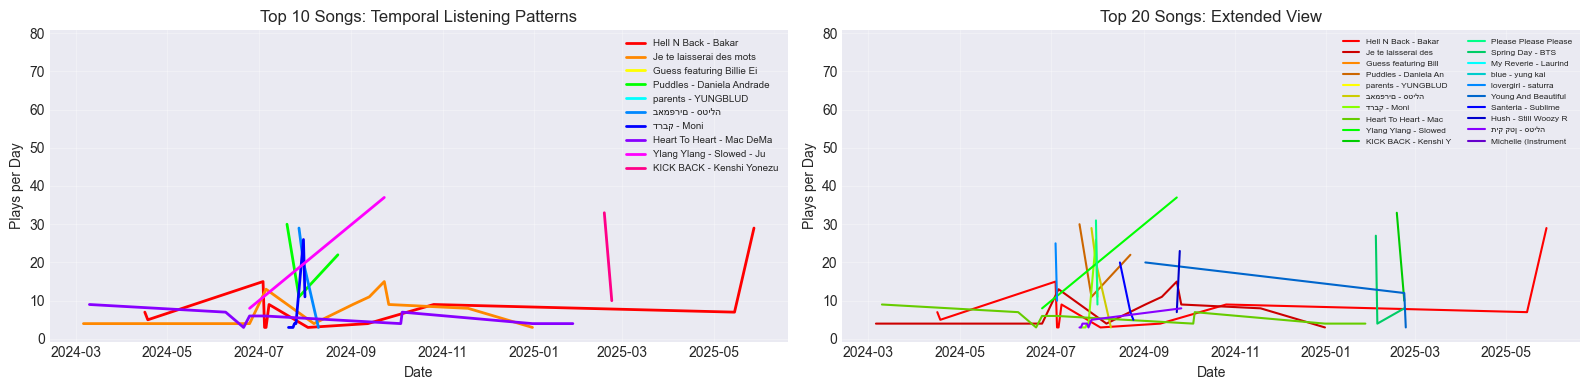


📊 Listening Statistics:
   Unique songs: 324
   Total plays (filtered): 3,209
   Mean plays per song-date: 6.60
   Median plays per song-date: 4


In [5]:
# Calculate play statistics
plays_per_song = combined_data.groupby('song')['play_count'].sum().sort_values(ascending=False)

# Create visualizations
colors_10 = ['#FF0000', '#FF8800', '#FFFF00', '#00FF00', '#00FFFF', 
             '#0088FF', '#0000FF', '#8800FF', '#FF00FF', '#FF0088']
colors_20 = ['#FF0000', '#CC0000', '#FF8800', '#CC6600', '#FFFF00', '#CCCC00',
             '#88FF00', '#66CC00', '#00FF00', '#00CC00', '#00FF88', '#00CC66',
             '#00FFFF', '#00CCCC', '#0088FF', '#0066CC', '#0000FF', '#0000CC',
             '#8800FF', '#6600CC', '#FF00FF', '#CC00CC', '#FF0088', '#CC0066']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Top 10 songs
top_10 = plays_per_song.head(10)
for i, song in enumerate(top_10.index):
    song_data = combined_data[combined_data['song'] == song].groupby('date')['play_count'].sum()
    axes[0].plot(song_data.index, song_data.values, label=song[:25], 
                 color=colors_10[i], linewidth=2)
axes[0].set_title('Top 10 Songs: Temporal Listening Patterns')
axes[0].legend(fontsize=7)
axes[0].grid(alpha=0.3)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Plays per Day')

# Top 20 songs
top_20 = plays_per_song.head(20)
for i, song in enumerate(top_20.index):
    song_data = combined_data[combined_data['song'] == song].groupby('date')['play_count'].sum()
    axes[1].plot(song_data.index, song_data.values, label=song[:20], 
                 color=colors_20[i], linewidth=1.5)
axes[1].set_title('Top 20 Songs: Extended View')
axes[1].legend(fontsize=6, ncol=2)
axes[1].grid(alpha=0.3)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Plays per Day')

plt.tight_layout()
plt.show()

print(f"\n📊 Listening Statistics:")
print(f"   Unique songs: {combined_data['song'].nunique()}")
print(f"   Total plays (filtered): {combined_data['play_count'].sum():,}")
print(f"   Mean plays per song-date: {combined_data['play_count'].mean():.2f}")
print(f"   Median plays per song-date: {combined_data['play_count'].median():.0f}")


#### 3.3.2 Word Frequency Analysis


For my journal data, I wanted to produce a similar graph but with the words that I used. I cleaned the most common words like I, me, the, them, and said. This will produce a more informative graph that will tell me about the trends of the words that I use. For instance, during the *Ylang-Ylang* period in Taiwan, you can see by the word trend that I was journaling about shin, night, funny, and nice. So when I talk about those things, we would hope that my machine learning model would choose the song *Ylang-Ylang*, or *Moni*, or whatever other song I was playing in that period. Similarly, I talk about mom and buses a lot in spring, meaning that I would hope that my model, whenever I talk about my mom and bus rides, would produce a song like *Hell N Back*, which is what I was listening to back then.

So some pattern like **during the Ylang-Ylang period in Taiwan, I frequently journaled about: "shin", "night", "funny", "nice"** I would like my model to learn. 

Note: There is definitely a more efficient way to filter out common words, but I wanted complete control over it myself, and simplicity given my pipeline, so I chose to do it manually.

📝 Word Frequency Analysis:
   Total words: 44,081
   Unique words: 3,780

   Top 20 Most Common Words:
    1. nice            - 343
    2. think           - 269
    3. hakkei          - 251
    4. night           - 235
    5. shin            - 226
    6. day             - 185
    7. funny           - 182
    8. people          - 178
    9. place           - 176
   10. mom             - 142
   11. bus             - 135
   12. hike            - 133
   13. gets            - 133
   14. arina           - 132
   15. see             - 131
   16. fun             - 129
   17. shit            - 129
   18. take            - 126
   19. today           - 125
   20. thought         - 118


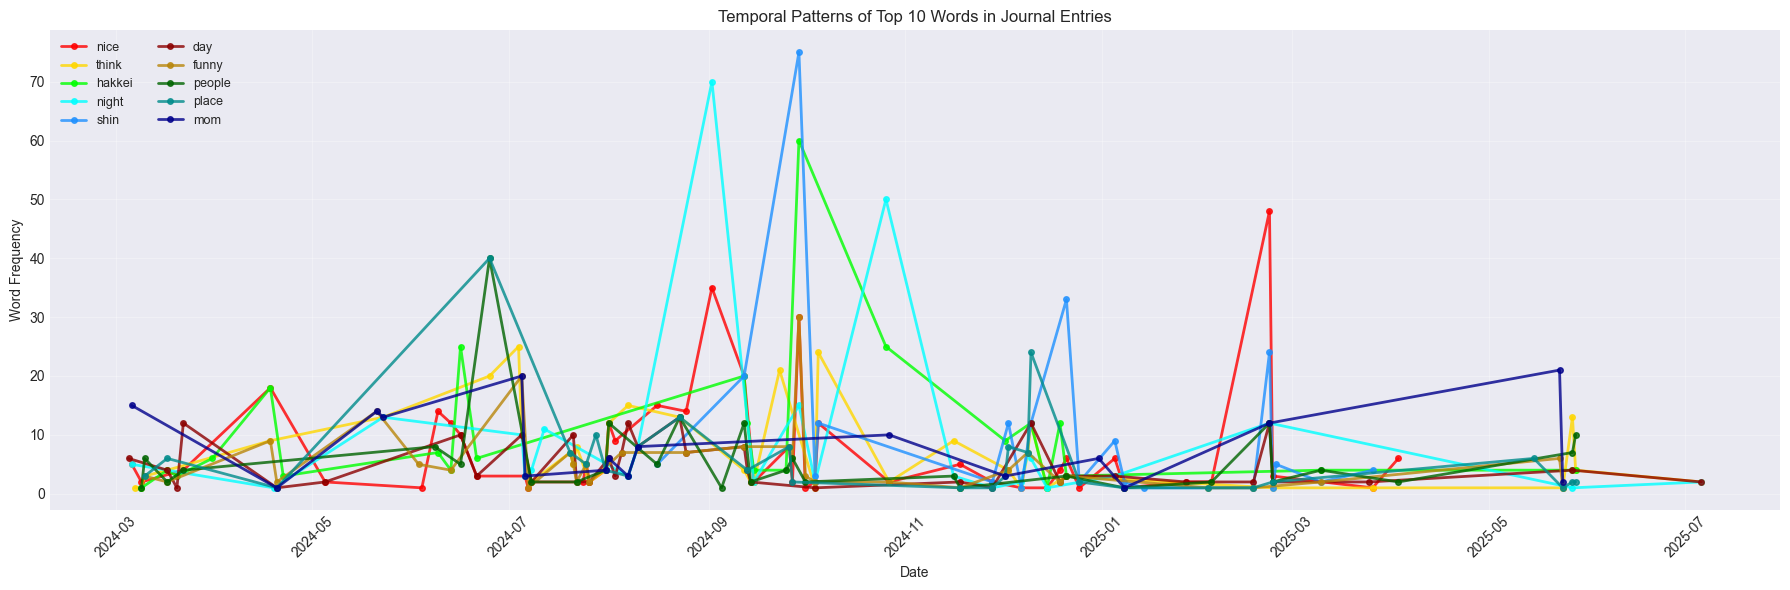

In [ ]:
# Define comprehensive stopwords
stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now',
    'like', 'really', 'anyways', 'know', 'get', 'got', 'one', 'well', 'went',
    'time', 'way', 'first', 'back', 'feel', 'good', 'coz', 'something', 'kinda', 'made',
    'would', 'everyone', 'around', 'also', 'said', 'say', 'thing', 'hakkei',
    'things', 'much', 'make', 'actually', 'lot', 'gonna', 'end', 'maybe', 'even', 
    'yeah', 'never', 'super', 'last', 'nothing'
}

# Extract and count words
all_words = [
    w for text in combined_data['journal_text_cleaned']
    for w in re.findall(r'\b[a-z]{3,}\b', text.lower())
    if w not in stopwords
]
word_counts = Counter(all_words)

print(f"📝 Word Frequency Analysis:")
print(f"   Total words: {len(all_words):,}")
print(f"   Unique words: {len(word_counts):,}")
print(f"\n   Top 20 Most Common Words:")
for i, (word, count) in enumerate(word_counts.most_common(20), 1):
    print(f"   {i:2d}. {word:15s} - {count:3d}")

# Visualize temporal word patterns
top_10_words = [word for word, count in word_counts.most_common(10)]
word_dates = {word: {} for word in top_10_words}

for date, text in combined_data.groupby('date')['journal_text'].apply(' '.join).items():
    words = [w for w in re.findall(r'\b[a-z]{3,}\b', text.lower()) if w not in stopwords]
    for word in top_10_words:
        if word in words:
            word_dates[word][date] = words.count(word)

colors = ['#FF0000', '#FFD700', '#00FF00', '#00FFFF', '#1E90FF',
          '#8B0000', '#B8860B', '#006400', '#008B8B', '#00008B']

plt.figure(figsize=(18, 6))
for i, word in enumerate(top_10_words):
    dates = list(word_dates[word].keys())
    counts = list(word_dates[word].values())
    if dates:
        plt.plot(dates, counts, linewidth=2, alpha=0.8, color=colors[i], 
                 label=word, marker='o', markersize=4)

plt.xlabel('Date')
plt.ylabel('Word Frequency')
plt.title('Temporal Patterns of Top 10 Words in Journal Entries')
plt.xticks(rotation=45)
plt.legend(fontsize=9, loc='upper left', ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The core of my approach is **metric learning using triplet networks**. I need to structure my data into triplets that teach models which journal entries should be close together (similar moods/eras) and which should be far apart (different moods/eras).

#### Mathematical Framework

A **triplet** consists of three elements:

- **Anchor (A)**: A journal entry for song \(S\) on date \(D_1\)
- **Positive (P)**: A different journal entry for the same song \(S\) on date \(D_2\)
- **Negative (N)**: A journal entry for a different song with **no temporal overlap** with \(S\)

The goal is to learn embeddings where:

$$
d(A, P) < d(A, N)
$$

where $d(., .)$ is cosine distance in embedding space.

#### Why This Structure?

Positive pairs captures the mood space so by pairing different journal entries for the same some I am basically telling the model "hey man these two pieces of text, even though the are about different events are in the same emotional era." So if one day I am eating dumplings and the other I am hanging out with Shin, if I listened to Ylang Ylang then they are basically in the same "era."

Negative pairs have no temporal overlap, so they have NO era in common, and this way I ensure the model learns to distribuish between my different "eras." So if I was listening to Song A and march doing whatever I was doing in march and I was listening to Song B in September doing whatever I was doing in September as long as they have no overlap I want to push these as far away from eachother as possible in my embedding space. I do this by for a song I find all the dates where the song was played and then I find the songs where they were not played on any of those dates I make Negative pairs from songs that have no overlap. 

Note to prevent bias we select equal positive pairs and negative pairs for training, originally we had more negative pairs, but we cut them down. 

#### Example

Here is a triplet for **“(They Long To Be) Close To You – Carpenters”**:

- **Anchor**: Written in early December about going to Japan  
- **Positive**: Written on December 25 about Kusatsu onsen  
- **Negative**: Written in March about a completely different period

Even without seeing the dates, the model should learn that the **December entries** (which both mention travel, winter activities, holidays, and similar emotional tones) are more similar to each other than to the March entry about school assignments and the assignment grind. 

In [7]:
# Create positive pairs (same song, different dates)
df_positive_pairs = pd.DataFrame([
    {'song': song, 'journal_text_1': t1, 'journal_text_2': t2}
    for song, texts in combined_data.groupby('song')['journal_text_cleaned'].apply(lambda x: list(x.unique())).items()
    if len(texts) >= 2
    for t1, t2 in combinations(texts, 2)
])

print(f"✅ Created {len(df_positive_pairs)} positive pairs from {df_positive_pairs['song'].nunique()} songs")

# Create negative pairs (no temporal overlap)
df = combined_data.reset_index(drop=True)
song_to_dates = df.groupby('song')['date'].apply(set).to_dict()
date_to_songs = df.groupby('date')['song'].apply(set).to_dict()

def get_unrelated_songs(song):
    """Find songs with no temporal overlap"""
    related = set()
    for date in song_to_dates.get(song, set()):
        related.update(date_to_songs[date])
    return set(df['song'].unique()) - related

import random

df_negative_pairs = pd.DataFrame([
    {
        'song_pos': song,
        'journal_text_pos': df[df['song'] == song].sample(1, random_state=abs(hash(song)) % (2**31) + i).iloc[0]['journal_text_cleaned'],
        'song_neg': (neg_song := random.Random(abs(hash(song)) % (2**31) + i + 1000).choice(list(get_unrelated_songs(song)))),
        'journal_text_neg': df[df['song'] == neg_song].sample(1, random_state=abs(hash(song)) % (2**31) + i + 2000).iloc[0]['journal_text_cleaned']
    }
    for song, n_pairs in df_positive_pairs['song'].value_counts().items()
    for i in range(n_pairs)
])

print(f"✅ Created {len(df_negative_pairs)} negative pairs (matching {len(df_positive_pairs)} positive pairs)")

# Combine into triplets
negatives_by_song = df_negative_pairs.groupby('song_pos')['journal_text_neg'].apply(list).to_dict()

triplet_data = []
for song, group in df_positive_pairs.groupby('song'):
    negatives = negatives_by_song.get(song, [])
    for idx, row in group.iterrows():
        triplet_data.append({
            'song': song,
            'anchor_text': row['journal_text_1'],
            'positive_text': row['journal_text_2'],
            'negative_text': negatives[len(triplet_data) % len(negatives)] if negatives else ""
        })

df_triplets = pd.DataFrame(triplet_data)
print(f"✅ Created {len(df_triplets)} triplets from {df_triplets['song'].nunique()} songs")

# Display example triplet
print(f"\n📋 Example Triplet:")
example = df_triplets.iloc[0]
print(f"   Song: {example['song']}")
print(f"   Anchor: {example['anchor_text'][:100]}...")
print(f"   Positive: {example['positive_text'][:100]}...")
print(f"   Negative: {example['negative_text'][:100]}...")


✅ Created 339 positive pairs from 94 songs
✅ Created 339 negative pairs (matching 339 positive pairs)
✅ Created 339 triplets from 94 songs

📋 Example Triplet:
   Song: (They Long To Be) Close To You - Carpenters
   Anchor: whatever fast forward to today, you don't have context or anything but i am going to japan. i was su...
   Positive: dec 25 kusatsu onsen for me shin before we continue to your decide to go to this hotspring place cal...
   Negative: i didn't take off except for special occasions. they looked like this drawing and i really liked the...


## 4. Model Selection & Theory
 



For Assignment 2, I implement and compare several different models to understand which approach best captures nostalgic associations:

1. **TF-IDF Baseline**: A classical NLP approach with **no neural networks, basically this determines if we really needed to code a bunch of NNs for this problem**
2. **Sentence-BERT (SBERT)**: A pretrained transformer model that I **fine-tune** on my triplet data.
3. **Variational Autoencoder (VAE)**: A generative latent space model that learns a continuous representation of moods from scratch.

### 4.1 TF-IDF

#### Why Include a Baseline?
Before jumping to complex neural models, I need a baseline to validate whether deep learning is actually necessary. TF-IDF (Term Frequency–Inverse Document Frequency) represents the classical NLP approach and serves as a sanity check. If my neural models don't outperform TF-IDF either DL is terribly unecessary or something is going wrong.

#### How TF-IDF Works
TF-IDF converts text into numerical vectors based on word importance. For each word \(w\) in each journal \(j\):

$$
\text{TF-IDF}(w, j) = \text{TF}(w, j) \times \text{IDF}(w)
$$

where:

- **TF (Term Frequency)**: How often word \(w\) appears in journal \(j\):

$$
\text{TF}(w, j) = \frac{\text{count of } w \text{ in } j}{\text{total words in } d}
$$

- **IDF (Inverse Document Frequency)**: How rare word \(w\) is across all journals:

$$
\text{IDF}(w) = \log\frac{\text{total journals}}{\text{journals containing } w}
$$

#### Intuition
So words that appear frequently in one journal but rarely in others get high scores (e.g., “dumplings” in my Taiwan entries), and common words that appear in all journals get low scores (e.g., “the”, “and”), then the model can compare journals by cosine similarity of their TF-IDF vectors. But again this is just based on frequency really and has nothing to do with feelings or mood representations which is why we don't really expect it to work well. 

#### Implementation Details

```python
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
```

Parameters chosen:
1. **max_features=5000**: Limit vocabulary to 5000 most important words to avoid overfitting given that my data is still small. 
2. **ngram_range=(1, 2)**: Consider both individual words (“Taiwan”) and bigrams (“night market”), as bigrams can capture more semantic meaning.

#### Why TF-IDF is going to perform terribly
TF-IDF has no concept of semantic similarity, in other words we have that words like “Happy” and “joyful” are treated as completely different words. However, it's computationally efficient and interpretable, making it a strong baseline, but for the purpose of the assignment I predict it will be pretty incompetent.So off the bat I already know the TF-IDF will perform terribly, but let us just make sure, and use it as a baseline for my other two models. 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print("🔄 Training TF-IDF baseline...")

# Fit TF-IDF on all journal texts
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
all_texts = combined_data['journal_text_cleaned'].unique()
tfidf.fit(all_texts)

# Transform train/test texts
def evaluate_tfidf(dataset, model_name="TF-IDF"):
    anchor_emb = tfidf.transform(dataset["anchor_text"]).toarray()
    pos_emb = tfidf.transform(dataset["positive_text"]).toarray()
    neg_emb = tfidf.transform(dataset["negative_text"]).toarray()
    
    pos_sim = [
        cosine_similarity([anchor_emb[i]], [pos_emb[i]])[0][0]
        for i in range(len(anchor_emb))
    ]
    neg_sim = [
        cosine_similarity([anchor_emb[i]], [neg_emb[i]])[0][0]
        for i in range(len(anchor_emb))
    ]
    
    correct = sum(p > n for p, n in zip(pos_sim, neg_sim))
    accuracy = correct / len(anchor_emb)
    separation = np.mean(pos_sim) - np.mean(neg_sim)
    
    # MRR calculation
    mrr_scores = []
    for i in range(len(anchor_emb)):
        candidates = [pos_emb[i]] + [neg_emb[j] for j in range(len(neg_emb))]
        similarities = [
            cosine_similarity([anchor_emb[i]], [c])[0][0]
            for c in candidates
        ]
        ranked_indices = np.argsort(similarities)[::-1]
        rank = np.where(ranked_indices == 0)[0][0] + 1
        mrr_scores.append(1.0 / rank)
    
    mrr = np.mean(mrr_scores)
    
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"📊 Triplet Accuracy: {accuracy:.2%} ({correct}/{len(anchor_emb)} correct)")
    print(f"📏 Embedding Separation: {separation:.4f}")
    print(f"🎯 Mean Reciprocal Rank (MRR): {mrr:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'accuracy': accuracy,
        'separation': separation,
        'mrr': mrr,
        'pos_sim': pos_sim,
        'neg_sim': neg_sim,
    }

🔄 Training TF-IDF baseline...


### 4.2 SBERT

#### 4.2.1 Model Selection Rationale

I chose Sentence-BERT as my primary model (again) because it represents the state-of-the-art for semantic similarity tasks while still being computationally feasible on my hardware. Sentence-BERT is based on BERT. BERT stands for "Bidirectional Encoder Representations from Transformers," as it uses layered encoders from transformer models to create word embeddings.

#### 4.2.2 BERT

As an input, BERT takes in two sentences, A and B, and tokenizes them for the model to be able to process. The architecture of the BERT tokenizer looks like this:

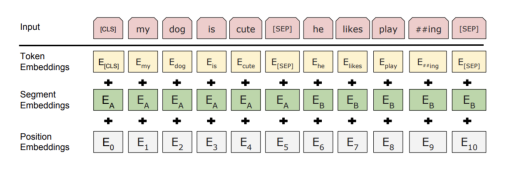

In [27]:
img = mpimg.imread('../images/img4.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Here, the token embeddings are trained separately and are word-piece embeddings, such as "ing." Each of these is assigned a value, and the vocabulary is built using algorithms that find frequent character sequences, in this case creating a vocabulary of 30,000 tokens. The segment embeddings distinguish between sentence A and sentence B, encoded as 0 or 1 in a vector for each token, and the position embeddings represent the position of that word within the sentence encoded into a vector. We sum these embeddings together element-wise to receive the input embedding passed into the BERT model, which also includes special tokens like [CLS] at the beginning for classification tasks and [SEP] to separate sentences. I parse my data so that it is in the format to be tokenized using HuggingFace. 

BERT optimizes by minimizing a loss function, which is the sum of the individual losses of its two learning objectives: MLM (Masked Language Modeling) and NSP (Next Sentence Prediction). 

The second individual objective function that BERT minimizes is the NSP, which gives a binary classification as an output for whether the second sentence goes after the first. This allowed BERT to perform better on sentence-level prediction.

This was a high-level overview of how the pretrained BERT model works.

#### The Problem with Vanilla BERT

Standard BERT requires concatenating two texts and running a forward pass to get their similarity and so we run into some problems like **Computational cost** is \(O(n^2)\) comparisons for \(n\) texts and **Inference time** because comparing one query against 1000 documents requires 1000 forward passes, and this then quickly becomes impractical for this project.

#### 4.2.3 SBERT (a solution)

SBERT computes embeddings for each text independently, then uses cosine similarity so in contrast its **Computational cost** is \(O(n)\) to embed all texts, then \(O(1)\) per similarity comparison; additionally its **Inference time** embeds the query once, then compares against pre-computed corpus embeddings.

#### Architecture Overview

Conceptually, SBERT looks like this:

```
Text A → BERT → Pooling → Embedding A ┐
                                       ├─> Cosine Similarity
Text B → BERT → Pooling → Embedding B ┘
```

The two BERT encoders are **Siamese networks** meaning that they share the exact same weights. So each encoder is inputted with a different sentence. The objective is to correctly predict whether the two sentences have a high cosine similarity or a low cosine similarity (don’t worry, I will go into the math of this later). By “Siamese,” it means that the two BERT models, even after fine-tuning, have the exact same parameters. We say SBERT is a fine-tuned version of the pretrained BERT model because we do not start training from scratch; rather, we reset some of the last layers of BERT and then optimize those.

#### Base Model: `all-distilroberta-v1`

I use `all-distilroberta-v1` as my pretrained base model for SBERT. This is a distilled version of RoBERTa that has been optimized for speed as it is 2x faster than the full RoBERTa while keeping like 95% of its performance. Also remember how I mentioned that BERT uses NSP? Well RoBERTa removed that; engineers performed some tests and discovered it was actually confusing the model, and by removing it, RoBERTa could focus on MLM and performed better, especially since it was trained on more data. 

### 4.2.4 Mathematical Foundation

#### Masked Language Modeling (MLM)

The core of BERT/RoBERTa is **Masked Language Modeling**:

$$
\mathcal{L}_{\text{MLM}} = -\mathbb{E}_{x \sim D}\left[\sum_{i \in \text{masked}} \log P(x_i \mid x_{\setminus i}; \theta)\right]
$$

where we have that \(x\) is the input sequence and \(x_{\setminus i}\) is the sequence with token \(i\) masked and \(\theta\) are the model parameters. 

MLM masks about 15% of tokens in the input, and its objective is to correctly guess the masked words. This is why BERT is called bidirectional, instead of the traditional word2vec that uses Skip-gram by predicting surrounding words from a center word, or uses CBOW by predicting the center word from surrounding context. MLM is different, as it learns from the context in both directions simultaneously, and even if you used separate forward and backward models, it still would not compare, as they'd process context in isolation instead of inferring directly from the full context jointly. Furthermore, BERT, as it uses the encoder architecture of a transformer, is able to create different embeddings for the same word, such as embedding the word "bat." Bat can be the animal, or like a baseball bat. Older models, such as word2vec, which process single words, are not able to create different embeddings for the same words and therefore perform worse at truly understanding language. BERT, which simultaneously takes in words, each time taking a different embedding for each piece of the sentence, is then able to produce polysemy.

### 4.2.5 SBERT Fine-Tuning with Triplet Loss

RoBERTa is pretrained on general language understanding, but I want it to learn **which journal entries represent similar temporal–emotional states** and so I fine-tune it specifically using **triplet loss** on my triplet dataset that I made earlier.

#### Triplet Loss Function

Vector embeddings closer together will have have a smaller angel in between them, while vector embedings further apart will have larger angel. We can compute exactly how close these vectors are by taking the cosine of the angle. Cosine of larger angles are close to 1, orthogonal vectors have cosine of 0, and smaller angles have cosine closer to 1.

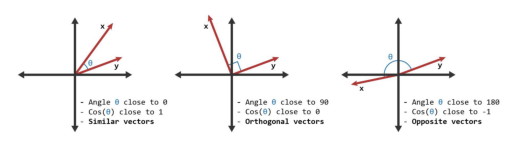

In [28]:
img = mpimg.imread('../images/img6.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Given an anchor \(A\), positive \(P\), and negative \(N\), the triplet loss is:

$$
\mathcal{L}_{\text{triplet}}(A, P, N)
= \max\bigl(0,\; d(A, N) - d(A, P) + \alpha\bigr)
$$

where the distance \(d(u, v)\) is defined as cosine distance:

$$
d(u, v) = 1 - \frac{u \cdot v}{\lVert u\rVert_2 \,\lVert v\rVert_2}
$$

and $\alpha = 0.5$ is the margin hyperparameter.


We want **positives closer than negatives** by at least margin $\alpha$. So If
  $$
  d(A, P) + 0.5 < d(A, N),
  $$

the constraint is satisfied and the loss is 0, and if the constraint is violated, the loss grows with how badly we violate it. Because of this framework it enforces a **“margin of safety”** rule that is like positives must be definitively closer, not just slightly closer. 

#### Backpropagation and Parameter Updates

Once the loss is computed, gradients flow backwards through the network and update the parameters just like in most neural networs:

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}_{\text{triplet}}
$$


We define $\eta = 2 \times 10^{-5}$ as the learning rate and $\nabla_\theta \mathcal{L}_{\text{triplet}}$ as the gradient of the loss with respect to the parameters/weights.

Note that I use a learning rate of $\eta = 2 \times 10^{-5}$, which is very small compared to training from scratch (typically \(10^{-3}\) to \(10^{-1}\)). This is because my model is already pretrained, so I just want to tweak it slightly and it does not need to make big steps. If I take pretrained steps it will not be conservative when it comes to updates as it might forget its pretrained knowledge. We are fine-tuning NOT retraining, it is conventional to use smaller learning rates for fine-tuning, as outlined in the SBERT documentation. 

### 4.2.6 Training Configuration

Sooo... I made several improvements from Assignment 1 which increased my accuracy from like only 55 (very supbar) to like over 80.

| Parameter     | Assignment 1 | Assignment 2 | Rationale |
|--------------|--------------|--------------|-----------|
| Epochs       | 1            | 3            | More exposure to training data, better convergence. |
| Batch size   | 8            | 2            | Smaller batches |
| Learning rate| 2e-5         | 2e-5         | Standard for fine-tuning; no change needed. |
| Margin       | 0.5          | 0.5          | Works well for cosine similarity. |


With only 271 training triplets I decreased my batch size from 8 which would have only like 34 gradient updates per epoch to a batch size of 2 which retains 135 gradient updates per epoch, this is 4x more paramter updates, which is very important for a small data set where each sample is precious. I mean I could augument my data with some other data from the internet now that I am thinking like books I read during the time, but I fear it would have some unecessary bias that might interfere with my goal. The tradeoff of my smaller batch size is that I will have noisier gradients (batch size 2 is less stable than 8), but I have a small learning rate so this is acceptible and may possibly help avoid sharp local minima.

I also increased from 1 to 3 epochs because validation accuracy was still improving after 1 epoch in Assignment 1. I just did not run it for more in Assignment 1 as my computer kept crashing, but now that I have smaller batch size I can increase it, literally the only issue was that I was not training for long enough haha. I did not go beyond 3 epochs because the validation loss plateaued during experimentation which was not so good.

In [11]:
# Data splitting
df_triplets = df_triplets.sample(frac=1, random_state=42).reset_index(drop=True)

train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1
train_size = int(train_frac * len(df_triplets))
valid_size = int(valid_frac * len(df_triplets))

df_train = df_triplets[:train_size]
df_valid = df_triplets[train_size:train_size + valid_size]
df_test = df_triplets[train_size + valid_size:]

print(f"✅ Data split:")
print(f"   Train: {len(df_train)} ({train_frac*100:.0f}%)")
print(f"   Valid: {len(df_valid)} ({valid_frac*100:.0f}%)")
print(f"   Test:  {len(df_test)} ({test_frac*100:.0f}%)")

# Convert to HuggingFace datasets
dataset = DatasetDict({
    "train": HFDataset.from_pandas(df_train),
    "validation": HFDataset.from_pandas(df_valid),
    "test": HFDataset.from_pandas(df_test)
})

# Load pretrained SBERT model
model_sbert = SentenceTransformer("sentence-transformers/all-distilroberta-v1", device="cpu")
print(f"✅ Loaded SBERT model: {model_sbert.device}")

# Initialize evaluator
evaluator_valid = TripletEvaluator(
    anchors=dataset["validation"]["anchor_text"],
    positives=dataset["validation"]["positive_text"],
    negatives=dataset["validation"]["negative_text"],
    name="journal-song-validation",
)
print(f"   Baseline validation accuracy: {evaluator_valid(model_sbert)['journal-song-validation_cosine_accuracy']:.2%}")


✅ Data split:
   Train: 271 (80%)
   Valid: 33 (10%)
   Test:  35 (10%)
✅ Loaded SBERT model: cpu
   Baseline validation accuracy: 60.61%


In [12]:

loss_sbert = losses.TripletLoss(
model_sbert,
distance_metric=losses.TripletDistanceMetric.COSINE,
triplet_margin=0.5
)


In [20]:
train_args = SentenceTransformerTrainingArguments(
output_dir="models/sbert-nostalgia-v2",
num_train_epochs=3,  # Increased from 1
per_device_train_batch_size=2,
per_device_eval_batch_size=2,
learning_rate=2e-5,
warmup_ratio=0.1,
eval_strategy="steps",
eval_steps=50,
save_steps=50,
logging_steps=25,
use_cpu=True,
load_best_model_at_end=True,
metric_for_best_model="journal-song-validation_cosine_accuracy",
)
print(f"✅ Training configuration set:")
print(f"   Epochs: {train_args.num_train_epochs}")
print(f"   Batch size: {train_args.per_device_train_batch_size}")
print(f"   Learning rate: {train_args.learning_rate}")
print(f"   Margin: {loss_sbert.triplet_margin}")


✅ Training configuration set:
   Epochs: 3
   Batch size: 2
   Learning rate: 2e-05
   Margin: 0.5


In [21]:
# SBERT fine-tuning on CPU using SentenceTransformer.fit (avoids MPS issues)
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

checkpoint_path = "models/sbert-nostalgia-v2/checkpoint-final"

# Always start from base SBERT on CPU
model_sbert = SentenceTransformer("sentence-transformers/all-distilroberta-v1", device="cpu")

# Build training examples from df_train (anchor, positive, negative)
train_examples = [
    InputExample(texts=[row["anchor_text"], row["positive_text"], row["negative_text"]])
    for _, row in df_train.iterrows()
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=train_args.per_device_train_batch_size)

# Use the previously defined triplet loss
train_loss = loss_sbert

# Compute warmup steps (10% of total steps)
num_epochs = train_args.num_train_epochs
warmup_steps = int(0.1 * len(train_dataloader) * num_epochs)

print("🔄 Fine-tuning SBERT on CPU with TripletLoss...")
model_sbert.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=int(num_epochs),
    warmup_steps=warmup_steps,
    show_progress_bar=True,
)

# Save fine-tuned model
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
model_sbert.save(checkpoint_path)
print(f"✅ SBERT fine-tuning complete. Model saved to {checkpoint_path}")

# Evaluate on validation set
final_score = evaluator_valid(model_sbert)
print(f"   Validation accuracy (cosine triplet): {final_score['journal-song-validation_cosine_accuracy']:.2%}")

🔄 Fine-tuning SBERT on CPU with TripletLoss...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


✅ SBERT fine-tuning complete. Model saved to models/sbert-nostalgia-v2/checkpoint-final
   Validation accuracy (cosine triplet): 81.82%


### 4.3 Variational Autoencoder (VAE)

#### 4.3.1 Why Add a VAE and What is it?

While SBERT uses pretrained knowledge I wanted to also test whether a model that learns the latent structure of my data from scratch (in embedding space) could be competitive... also I just want that 4 and I guess for that I need to train my own model. In my implementation, the VAE takes SBERT embeddings as input and then learns its **own** latent space and reconstruction behavior without any additional pretrained linguistic bias inside the VAE itself.

The VAE has a different approach:

- **SBERT**: Uses pretrained linguistic priors, then fine-tunes for my task.
- **VAE**: Randomly initialized encoder–decoder network on top of SBERT embeddings → learns structure purely from my data in embedding space.

The output of both approaches is a dense numerical representation (“mood embedding”), but the way they learn that space is very different.

#### Architecture

High-level pipeline:

```
Journal Text → SBERT → 768-dim embedding
                ↓
             Encoder (NN)
                ↓
       Latent Code z (128-dim)
```

In the *classical* VAE, we would have:

```
Journal Text (SBERT embedding: 768-dim)
    ↓
Encoder: Neural Network
    ↓
μ (mean) and log(σ²) (log-variance)
    ↓
Sampling: z = μ + σ ⊙ ε,   ε ~ N(0, I)
    ↓
Latent Code z (128-dim)
    ↓
Decoder: Neural Network
    ↓
Reconstructed embedding
```

In the *classical* VAE an encoder maps inputs into a Gaussian in latent space. The difference in my project is that I do this in SBERT embedding space so the encoder takes 768‑dim SBERT journal embeddings, compresses to latent space, and then a decoder network tries to reconstruct the original SBERT embedding. I then train this VAE with a combination of reconstruction loss (MSE in SBERT space) and KL divergence toward a standard normal prior on \(z\) inspired by CS146.

### 4.3.2 Mathematical Framework

#### 4.3.2.1 Encoder

The encoder maps input \(x\) (the 768‑dim journal text embedding from base SBERT) to latent distribution parameters:

$$
q_\phi(z \mid x) = \mathcal{N}\bigl(z; \mu_\phi(x), \sigma_\phi^2(x)\bigr)
$$

We have that $\mu_\phi(x) = W_\mu h + b_\mu$ is the mean of the latent distribution. Intuitively, this mean is like the “center of gravity” in my VAE mood space so if I sampled infinitely many latent codes for this journal entry then they’d all wobble around this point $\mu_\phi(x)$ which basically decides where that particular vibe lives in the latent space. The $\log \sigma_\phi^2(x) = W_\sigma h + b_\sigma$ is the log-variance which is like the opposite role than the mean, it controls how much wobble there is around that center. A small value of $\log \sigma_\phi^2(x)$ means all the journal entries would huddle tightly around the mean saying “I’m very sure what this mood looks like,” and a large value means the model is uncertain and spreads samples all over the place. Finally $h = \text{ReLU}(W_1 x + b_1)$ is the encoder hidden layer.

I predict log-variance instead of variance directly for numerical stability, as the variance must be positive and the log-variance can then be any real number, as it unconstrained optimization is just simpler than constrained.

#### 2. Reparameterization Trick

This is something that is really cool because I learnt it in CS146 this semester and it is applicable here too. To enable backpropagation through sampling, we use a reparameterization trick:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

Why this is necessary is because direct sampling $z \sim \mathcal{N}(\mu, \sigma^2)$ is not differentiable, and by seperating the separating stochasticity $(\epsilon$) from learned parameters $(\mu, \sigma$), gradients can now flow through $\mu_\phi(x)$ and $\sigma_\phi(x)$ which we can then differentiate and backpropagate.


### Architecture Details

**Encoder structure:**

Input: 768-dim (SBERT embedding)
    ↓
Linear(768 → 512) + BatchNorm + ReLU + Dropout(0.2)
    ↓
Linear(512 → 256) + BatchNorm + ReLU + Dropout(0.2)
    ↓
Linear(256 → 128) = Latent Code zDesign choices:

Here for the architecture, I slowly squish the 768‑dim SBERT embeddings down to 512, then 256, then 128, so at each step the network is forced to throw away redundant details and keep only the “essence” of the mood instead of memorizing everything. I chose a final latent layer size of 128 to be able to capture all scemantics. I use BatchNorm to keep the activations from going completely astray by normalizing them every layer this just makes the training way more stable, additionally during the actual training I also apply a dropout rate of 0.2 which basically means that 20% of the neurons are droped so that it doesn't lean to hard on a single feature and it is just made to generalize beyond my limited entries. The activation function everywhere is ReLU. 

Note that since we are training from a random initialization unlike SBERT fine tuning we need larger batch size of 32 and a more epochs of 50, furthermore the learning rate is increaase by 100 fold to the conventional training rate for from scratch models not pretrained.

### Data Preparation for VAE

VAE requires numerical inputs, so I:
1. Use SBERT to encode journal texts into 768-dim vectors
2. Create pairs of (journal_embedding, song_embedding)
3. Train VAE to reconstruct journal embeddings while learning meaningful latent structure


In [22]:
# Get SBERT embeddings for all unique journal texts
unique_texts = combined_data['journal_text_cleaned'].unique()
print(f"Encoding {len(unique_texts)} unique journal entries with SBERT...")


Encoding 100 unique journal entries with SBERT...


In [23]:
# Use base pretrained SBERT (not fine-tuned yet)
base_sbert = SentenceTransformer("sentence-transformers/all-distilroberta-v1", device="cpu")
text_embeddings = base_sbert.encode(unique_texts, show_progress_bar=True, convert_to_numpy=True)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
# Create mapping
text_to_embedding = {text: emb for text, emb in zip(unique_texts, text_embeddings)}


In [ ]:
class TripletVAE(nn.Module):
    """True VAE encoder/decoder trained on SBERT embeddings."""
    
    def __init__(self, embedding_dim=768, latent_dim=128):
        super().__init__()
        
        # Encoder: 768 → 256
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder: 128 → 768
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_dim),
        )
        
        self.latent_dim = latent_dim
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z
    
    def get_latent(self, x):
        """Use mean as deterministic latent for evaluation."""
        mu, logvar = self.encode(x)
        return mu

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction in SBERT-embedding space
    recon = F.mse_loss(recon_x, x, reduction="mean")
    # KL divergence to N(0, I)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

vae = TripletVAE(embedding_dim=768, latent_dim=128)
print("✅ VAE initialized:")
print("   Input dim: 768 (SBERT embeddings)")
print("   Latent dim: 128")
print(f"   Total parameters: {sum(p.numel() for p in vae.parameters()):,}")

optimizer_vae = optim.AdamW(vae.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_vae, T_max=50, eta_min=1e-5)

num_epochs_vae = 50
best_val_loss = float('inf')
history = {
    'train_loss': [],
    'train_recon': [],
    'train_kl': [],
    'valid_loss': [],
    'valid_recon': [],
    'valid_kl': []
}

print("🔄 Training VAE on SBERT embeddings...")

class TripletVAEDataset(torch.utils.data.Dataset):
    def __init__(self, df_triplets, base_encoder):
        print(f"   Encoding {len(df_triplets)} triplets...")
        self.anchors = base_encoder.encode(df_triplets['anchor_text'].tolist(), convert_to_numpy=True)
        self.positives = base_encoder.encode(df_triplets['positive_text'].tolist(), convert_to_numpy=True)
        self.negatives = base_encoder.encode(df_triplets['negative_text'].tolist(), convert_to_numpy=True)
    
    def __len__(self):
        return len(self.anchors)
    
    def __getitem__(self, idx):
        # Return three SBERT embeddings; we treat them as three data points
        return (
            torch.FloatTensor(self.anchors[idx]),
            torch.FloatTensor(self.positives[idx]),
            torch.FloatTensor(self.negatives[idx]),
        )

print("📦 Creating triplet datasets...")
train_triplet_dataset = TripletVAEDataset(df_train, base_sbert)
valid_triplet_dataset = TripletVAEDataset(df_valid, base_sbert)

train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_triplet_dataset, batch_size=32, shuffle=False)

print(f"✅ Created {len(train_triplet_dataset)} train, {len(valid_triplet_dataset)} valid triplets")

beta_kl = 1.0  # you can tune this

for epoch in range(num_epochs_vae):
    # ---------- Train ----------
    vae.train()
    train_loss = train_recon = train_kl = 0.0
    
    for anchor, positive, negative in train_loader:
        optimizer_vae.zero_grad()
        
        # Treat anchor, pos, neg as separate VAE inputs
        x = torch.cat([anchor, positive, negative], dim=0)
        recon, mu, logvar, z = vae(x)
        
        loss, recon_loss, kl_loss = vae_loss(recon, x, mu, logvar, beta=beta_kl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer_vae.step()
        
        train_loss += loss.item() * x.size(0)
        train_recon += recon_loss.item() * x.size(0)
        train_kl += kl_loss.item() * x.size(0)
    
    # ---------- Validate ----------
    vae.eval()
    valid_loss = valid_recon = valid_kl = 0.0
    
    with torch.no_grad():
        for anchor, positive, negative in valid_loader:
            x = torch.cat([anchor, positive, negative], dim=0)
            recon, mu, logvar, z = vae(x)
            
            loss, recon_loss, kl_loss = vae_loss(recon, x, mu, logvar, beta=beta_kl)
            
            valid_loss += loss.item() * x.size(0)
            valid_recon += recon_loss.item() * x.size(0)
            valid_kl += kl_loss.item() * x.size(0)
    
    # Averages
    n_train = len(train_loader.dataset) * 3
    n_valid = len(valid_loader.dataset) * 3
    
    train_loss /= n_train
    train_recon /= n_train
    train_kl /= n_train
    valid_loss /= n_valid
    valid_recon /= n_valid
    valid_kl /= n_valid
    
    history['train_loss'].append(train_loss)
    history['train_recon'].append(train_recon)
    history['train_kl'].append(train_kl)
    history['valid_loss'].append(valid_loss)
    history['valid_recon'].append(valid_recon)
    history['valid_kl'].append(valid_kl)
    
    scheduler.step()
    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(vae.state_dict(), 'models/vae_triplet_best.pth')
    
    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch+1:3d}/{num_epochs_vae} | "
            f"Loss: {train_loss:.4f} → {valid_loss:.4f} | "
            f"Recon: {train_recon:.4f} → {valid_recon:.4f} | "
            f"KL: {train_kl:.4f} → {valid_kl:.4f} | "
            f"LR: {optimizer_vae.param_groups[0]['lr']:.2e}"
        )

print(f"✅ VAE training complete. Best val loss: {best_val_loss:.4f}")
vae.load_state_dict(torch.load('models/vae_triplet_best.pth'))

✅ Triplet VAE initialized:
   Input dim: 768 (SBERT embeddings)
   Latent dim: 128
   Total parameters: 559,488
   Architecture: Pure encoder (no decoder)
🔄 Training Triplet VAE (pure metric learning)...
📦 Creating triplet datasets...
   Encoding 271 triplets...
   Encoding 33 triplets...
✅ Created 271 train, 33 valid triplets
Epoch   5/50 | Loss: 0.0203 → 0.1567 | Pos: 0.428 → 0.347 | Neg: -0.119 → -0.092 | Sep: 0.439 | LR: 9.76e-04
Epoch  10/50 | Loss: 0.0168 → 0.1235 | Pos: 0.447 → 0.364 | Neg: -0.190 → -0.130 | Sep: 0.494 | LR: 9.05e-04
Epoch  15/50 | Loss: 0.0130 → 0.1560 | Pos: 0.438 → 0.357 | Neg: -0.209 → -0.127 | Sep: 0.484 | LR: 7.96e-04
Epoch  20/50 | Loss: 0.0065 → 0.1737 | Pos: 0.443 → 0.322 | Neg: -0.225 → -0.141 | Sep: 0.463 | LR: 6.58e-04
Epoch  25/50 | Loss: 0.0031 → 0.1567 | Pos: 0.463 → 0.341 | Neg: -0.224 → -0.144 | Sep: 0.484 | LR: 5.05e-04
Epoch  30/50 | Loss: 0.0042 → 0.1436 | Pos: 0.463 → 0.336 | Neg: -0.237 → -0.172 | Sep: 0.508 | LR: 3.52e-04
Epoch  35/50 | Lo

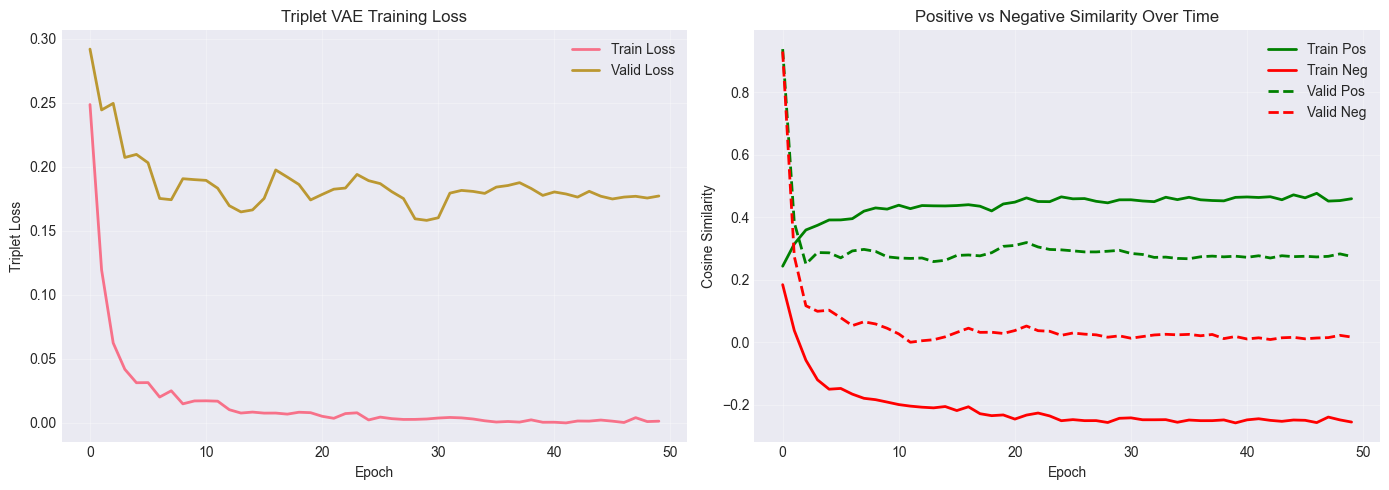


📈 Training Summary:
   Initial separation: 0.0590
   Final separation: 0.2578
   Improvement: 0.1988


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss over time
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['valid_loss'], label='Valid Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Triplet Loss')
axes[0].set_title('Triplet VAE Training Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Similarity trends
axes[1].plot(history['train_pos_sim'], label='Train Pos', linewidth=2, color='green')
axes[1].plot(history['train_neg_sim'], label='Train Neg', linewidth=2, color='red')
axes[1].plot(history['valid_pos_sim'], label='Valid Pos', linewidth=2, linestyle='--', color='green')
axes[1].plot(history['valid_neg_sim'], label='Valid Neg', linewidth=2, linestyle='--', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Positive vs Negative Similarity Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Training Summary:")
print(f"   Initial separation: {history['train_pos_sim'][0] - history['train_neg_sim'][0]:.4f}")
print(f"   Final separation: {history['valid_pos_sim'][-1] - history['valid_neg_sim'][-1]:.4f}")
print(f"   Improvement: {(history['valid_pos_sim'][-1] - history['valid_neg_sim'][-1]) - (history['train_pos_sim'][0] - history['train_neg_sim'][0]):.4f}")

We can see how in the second image we start at no seperation between positive and negative pairs but then we get more and more seperation. The validation loss is significantly higher than our triplet loss which definetly means we are over fitting, but it is to be expected to some point. This is a limitation of this paper, and could use further fine tuning and improvement. 

# 6. Model Evaluation

### 6.1 Metrics

#### 6.1.1 Metric 1: Triplet Accuracy

Percentage of triplets where the positive is closer to the anchor than the negative:

$$
d(A, P) < d(A, N)
$$

Formally, for $N$ triplets $(A_i, P_i, N_i)$:

$$
\text{Accuracy} = \frac{1}{N}\sum_{i=1}^{N} \mathbb{1}\big[d(A_i, P_i) < d(A_i, N_i)\big]
$$

We can interpret this accuracy number as 50% would be like a random baseline like flipping a coin (fun fact my VAE at virst was performing at 32% which is WORSE than random), something like 60-75 is like weak signal like the model has learn something but it is not that robust at determining our "eras," finally an 75-90% is pretty strong as it can distinguish different eras, just not perfectly. 90-100% is basically perfect and ideal, but it might indicate that our model might have some data leakage or something, I feel like this is not a realistic goal, given the complexity.

This matters as it evaluates whether similar eras are closer than dissimilar ones based on my negative and positive pairings, it is also very easy to interpret and calculate as it is a binary score.

#### 6.1.2 Metric 2: Embedding Separation

Mean difference between positive and negative cosine similarities:

$$
\text{Separation} = \mathbb{E}[\text{sim}(A, P)] - \mathbb{E}[\text{sim}(A, N)]
$$

where $\text{sim}(\cdot, \cdot)$ is cosine similarity.

So if we have a seperation of like 0 this means that we are not seperating between positive and negative pairs, and it is hard to like distinguish between wich song will correspond to which era. This is particularly difficult for my data as there is SO much overlap in between eras. A seperation of like 0.1 is small but pretty measurable, while like 0.2 is doing pretty well and is measurable, and a seperation of 0.3 or greater is ideal as there is a strong distinction.

#### 6.1.3 Metric 3: Mean Reciprocal Rank (MRR)

For each anchor, I rank all candidate songs by similarity and look at the position of the correct (positive) one. The reciprocal rank for that anchor is:

$$
\text{RR}_i = \frac{1}{\text{rank}_i}
$$

Then I average over all anchors:

$$
\text{MRR} = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{\text{rank}_i}
$$

So we compute this by for each anchor $A_u$ we evaluate the similarities to all the candidate songs and then we rank these songs in descending order of similarity, we then find the rank of the correct positive song and convert that to a reciprocal rank so a rank 1 would eb a score of 1 and like a rank of 2 would be a score of 0.5, we would then average those scores across all anchors.  So the higher MRR the better if it is 1 this means its perfect. 

I think the Accuracy and Seperation matters the most as I have several songs per entry and the MRR has only 1 correct answer and honestly, there are several correct options which the MRR does not account for, I care that we can match our journal entry to a nostalgic era, but there are many correct nostalgic eras for each entry, so I expect MRR to be pretty low.

In [30]:
from sentence_transformers.util import cos_sim


In [50]:
def evaluate_model(model, dataset, model_name="Model", use_vae=False):
    """Comprehensive evaluation metrics for both SBERT and VAE"""
    if use_vae:
        # For VAE, encode texts first
        base_encoder = SentenceTransformer("sentence-transformers/all-distilroberta-v1", device="cpu")
        anchor_emb_raw = base_encoder.encode(dataset["anchor_text"], convert_to_tensor=True)
        pos_emb_raw = base_encoder.encode(dataset["positive_text"], convert_to_tensor=True)
        neg_emb_raw = base_encoder.encode(dataset["negative_text"], convert_to_tensor=True)

        # Get VAE latent embeddings
        model.eval()
        with torch.no_grad():
            anchor_emb = model.get_latent(anchor_emb_raw).cpu().numpy()
            pos_emb = model.get_latent(pos_emb_raw).cpu().numpy()
            neg_emb = model.get_latent(neg_emb_raw).cpu().numpy()
    else:
        # For SBERT, direct encoding
        anchor_emb = model.encode(dataset["anchor_text"], convert_to_numpy=True)
        pos_emb = model.encode(dataset["positive_text"], convert_to_numpy=True)
        neg_emb = model.encode(dataset["negative_text"], convert_to_numpy=True)

    # Compute similarities
    pos_sim = [
        cos_sim(torch.tensor(anchor_emb[i]), torch.tensor(pos_emb[i])).item()
        for i in range(len(anchor_emb))
    ]
    neg_sim = [
        cos_sim(torch.tensor(anchor_emb[i]), torch.tensor(neg_emb[i])).item()
        for i in range(len(anchor_emb))
    ]

    # Metric 1: Triplet Accuracy
    correct = sum(p > n for p, n in zip(pos_sim, neg_sim))
    accuracy = correct / len(anchor_emb)

    # Metric 2: Embedding Separation
    separation = np.mean(pos_sim) - np.mean(neg_sim)

    # Metric 3: Mean Reciprocal Rank (MRR)
    # For each anchor, rank positive among all possible pairs
    mrr_scores = []
    for i in range(len(anchor_emb)):
        # Create candidate pool: positive + all negatives
        candidates = [pos_emb[i]] + [neg_emb[j] for j in range(len(neg_emb))]
        similarities = [
            cos_sim(torch.tensor(anchor_emb[i]), torch.tensor(c)).item()
            for c in candidates
        ]

        # Rank (higher similarity = better rank)
        ranked_indices = np.argsort(similarities)[::-1]
        rank = np.where(ranked_indices == 0)[0][0] + 1  # +1 because rank starts at 1
        mrr_scores.append(1.0 / rank)

    mrr = np.mean(mrr_scores)

    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"📊 Triplet Accuracy: {accuracy:.2%} ({correct}/{len(anchor_emb)} correct)")
    print(f"📏 Embedding Separation: {separation:.4f}")
    print(f"   - Positive pairs mean: {np.mean(pos_sim):.4f} (±{np.std(pos_sim):.4f})")
    print(f"   - Negative pairs mean: {np.mean(neg_sim):.4f} (±{np.std(neg_sim):.4f})")
    print(f"🎯 Mean Reciprocal Rank (MRR): {mrr:.4f}")
    print(f"{'='*60}\n")

    return {
        'accuracy': accuracy,
        'separation': separation,
        'mrr': mrr,
        'pos_sim': pos_sim,
        'neg_sim': neg_sim,
    }


In [ ]:
# TF-IDF baseline
results_tfidf = evaluate_tfidf(
    dataset["test"], 
    model_name="TF-IDF Baseline"
)


TF-IDF Baseline Evaluation Results
📊 Triplet Accuracy: 60.00% (21/35 correct)
📏 Embedding Separation: 0.0043
🎯 Mean Reciprocal Rank (MRR): 0.1122



In [ ]:
# Evaluate SBERT
results_sbert = evaluate_model(
    model_sbert, dataset["test"], 
    model_name="SBERT (Fine-tuned)", 
    use_vae=False
)



SBERT (Fine-tuned) Evaluation Results
📊 Triplet Accuracy: 77.14% (27/35 correct)
📏 Embedding Separation: 0.2613
   - Positive pairs mean: 0.3087 (±0.2286)
   - Negative pairs mean: 0.0474 (±0.3174)
🎯 Mean Reciprocal Rank (MRR): 0.1543



In [51]:
# Evaluate VAE
results_vae = evaluate_model(
    vae, dataset["test"], 
    model_name="VAE (Latent Space)", 
    use_vae=True
)



VAE (Latent Space) Evaluation Results
📊 Triplet Accuracy: 77.14% (27/35 correct)
📏 Embedding Separation: 0.3761
   - Positive pairs mean: 0.3024 (±0.3299)
   - Negative pairs mean: -0.0737 (±0.3267)
🎯 Mean Reciprocal Rank (MRR): 0.1820



## 6.2 Comparative Analysis


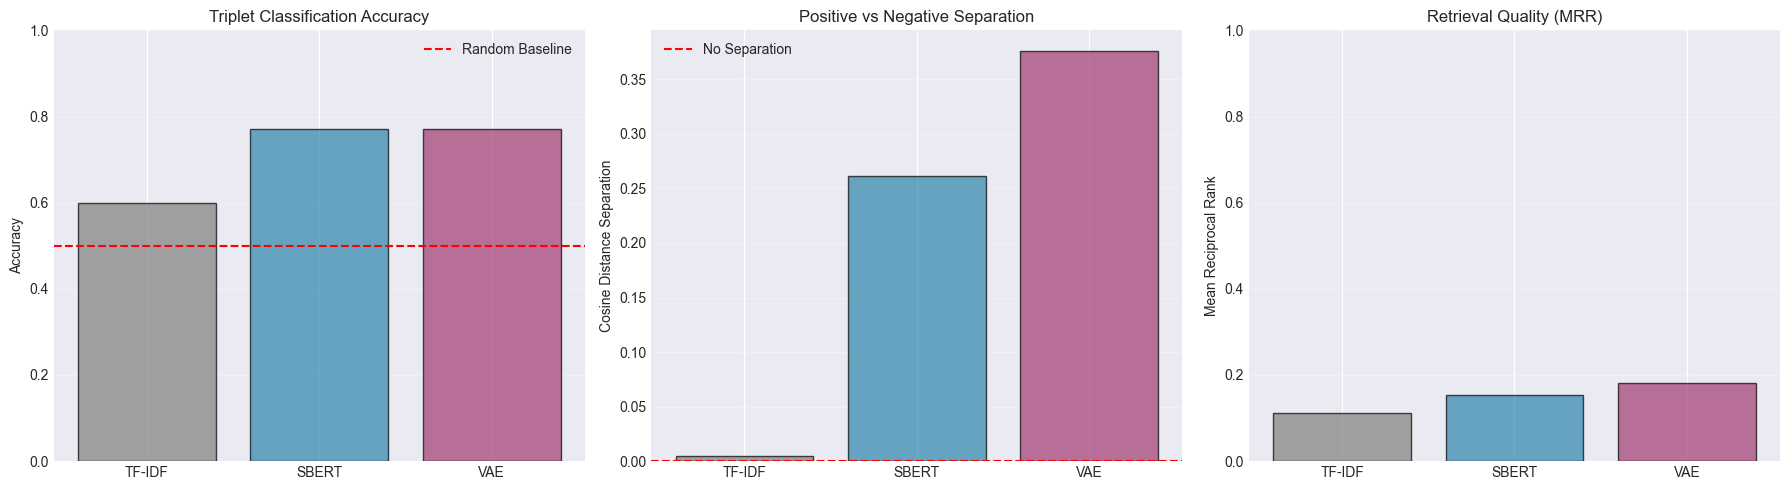


📈 Model Comparison Summary:
   TF-IDF  | Accuracy: 60.00% | Separation: 0.0043 | MRR: 0.1122
   SBERT   | Accuracy: 77.14% | Separation: 0.2613 | MRR: 0.1543
   VAE     | Accuracy: 77.14% | Separation: 0.3761 | MRR: 0.1820


In [57]:
# Comparison visualization (TF-IDF vs SBERT vs VAE)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = ["TF-IDF", "SBERT", "VAE"]
model_results = [results_tfidf, results_sbert, results_vae]
colors = ["#7F7F7F", "#2E86AB", "#A23B72"]

# Metric 1: Triplet Accuracy
accuracies = [r["accuracy"] for r in model_results]
axes[0].bar(model_names, accuracies, color=colors, alpha=0.7, edgecolor="black")
axes[0].axhline(0.5, color="red", linestyle="--", label="Random Baseline")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Triplet Classification Accuracy")
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(alpha=0.3, axis="y")

# Metric 2: Embedding Separation
separations = [r["separation"] for r in model_results]
axes[1].bar(model_names, separations, color=colors, alpha=0.7, edgecolor="black")
axes[1].axhline(0, color="red", linestyle="--", label="No Separation")
axes[1].set_ylabel("Cosine Distance Separation")
axes[1].set_title("Positive vs Negative Separation")
axes[1].legend()
axes[1].grid(alpha=0.3, axis="y")

# Metric 3: MRR
mrrs = [r["mrr"] for r in model_results]
axes[2].bar(model_names, mrrs, color=colors, alpha=0.7, edgecolor="black")
axes[2].set_ylabel("Mean Reciprocal Rank")
axes[2].set_title("Retrieval Quality (MRR)")
axes[2].set_ylim([0, 1])
axes[2].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📈 Model Comparison Summary:")
for name, res in zip(model_names, model_results):
    print(
        f"   {name:7s} | "
        f"Accuracy: {res['accuracy']:.2%} | "
        f"Separation: {res['separation']:.4f} | "
        f"MRR: {res['mrr']:.4f}"
    )

We can see that SBERT and VAE does significantly outperform the TF-IDF in terms of accuracy with both sitting at 77.14% accuracy (SO GOOD!) and TF-IDF sitting at only 60% which validates that we do in fact need deep learning for this project. We can see how the TF-IDF has basically no seperation what-so-ever, meaning that it cannot differentiat that well between different eras, meanwhile SBERT has a seperation of 0.25 and VAE has a seperation of 0.37 which is really good. This means the VAE outperforms the SBERT by being able to seperate the eras better. The MRR is pretty low for all three as I predicted. There is no ONE era for each entry and so this is understandable. 

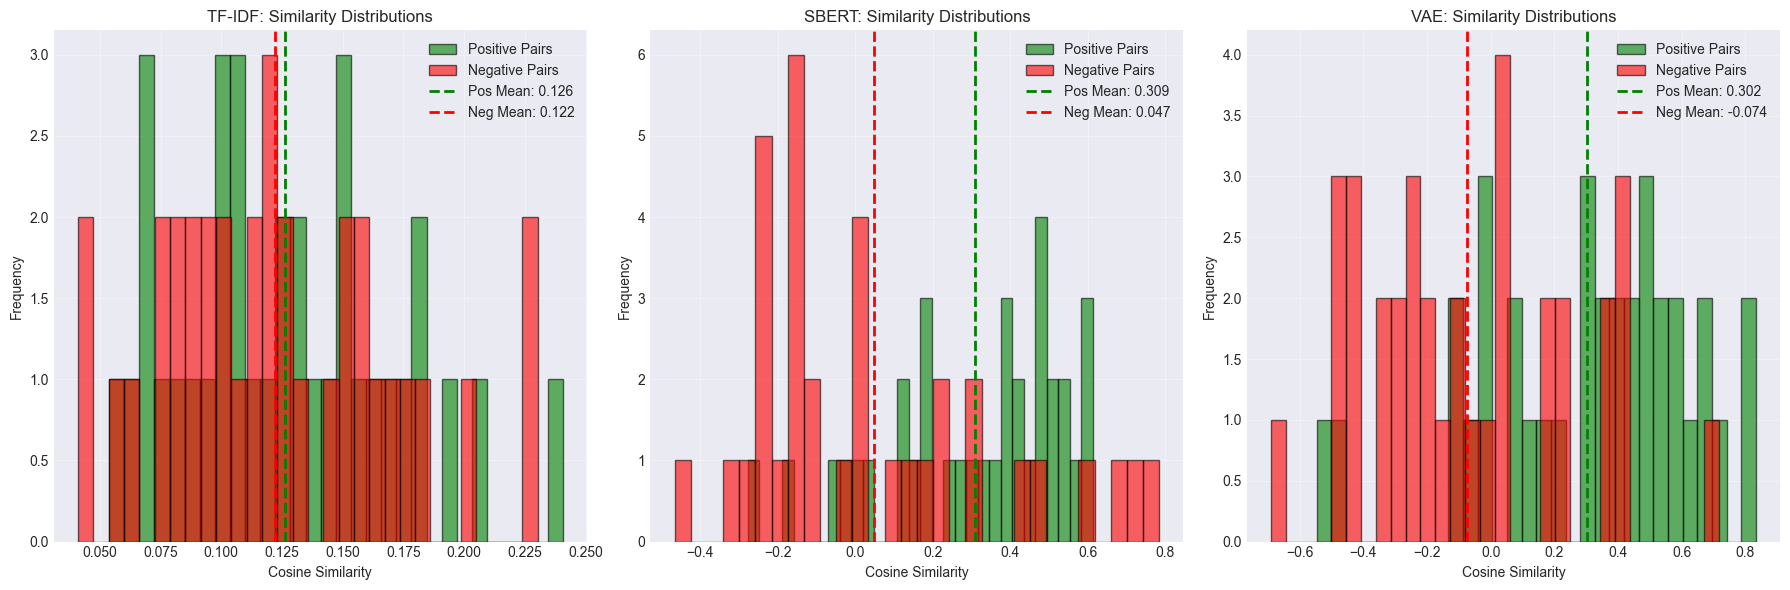

In [58]:
### Distribution Analysis

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

model_results = [
    (results_tfidf, "TF-IDF"),
    (results_sbert, "SBERT"),
    (results_vae, "VAE"),
]

for ax, (res, name) in zip(axes, model_results):
    ax.hist(res["pos_sim"], bins=30, alpha=0.6,
            label="Positive Pairs", color="green", edgecolor="black")
    ax.hist(res["neg_sim"], bins=30, alpha=0.6,
            label="Negative Pairs", color="red", edgecolor="black")

    ax.axvline(np.mean(res["pos_sim"]), color="green", linestyle="--",
               linewidth=2, label=f'Pos Mean: {np.mean(res["pos_sim"]):.3f}')
    ax.axvline(np.mean(res["neg_sim"]), color="red", linestyle="--",
               linewidth=2, label=f'Neg Mean: {np.mean(res["neg_sim"]):.3f}')

    ax.set_xlabel("Cosine Similarity")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{name}: Similarity Distributions")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Here we can see the seperations better... And we can see how VAE and SBERT are pretty far a part for TF-IDF they are almost lying on top of eachother. 


TF-IDF Classification Metrics:
   Precision: 53.33%
   Recall:    68.57%
   F1-Score:  60.00%

SBERT Classification Metrics:
   Precision: 70.73%
   Recall:    82.86%
   F1-Score:  76.32%

VAE Classification Metrics:
   Precision: 72.97%
   Recall:    77.14%
   F1-Score:  75.00%


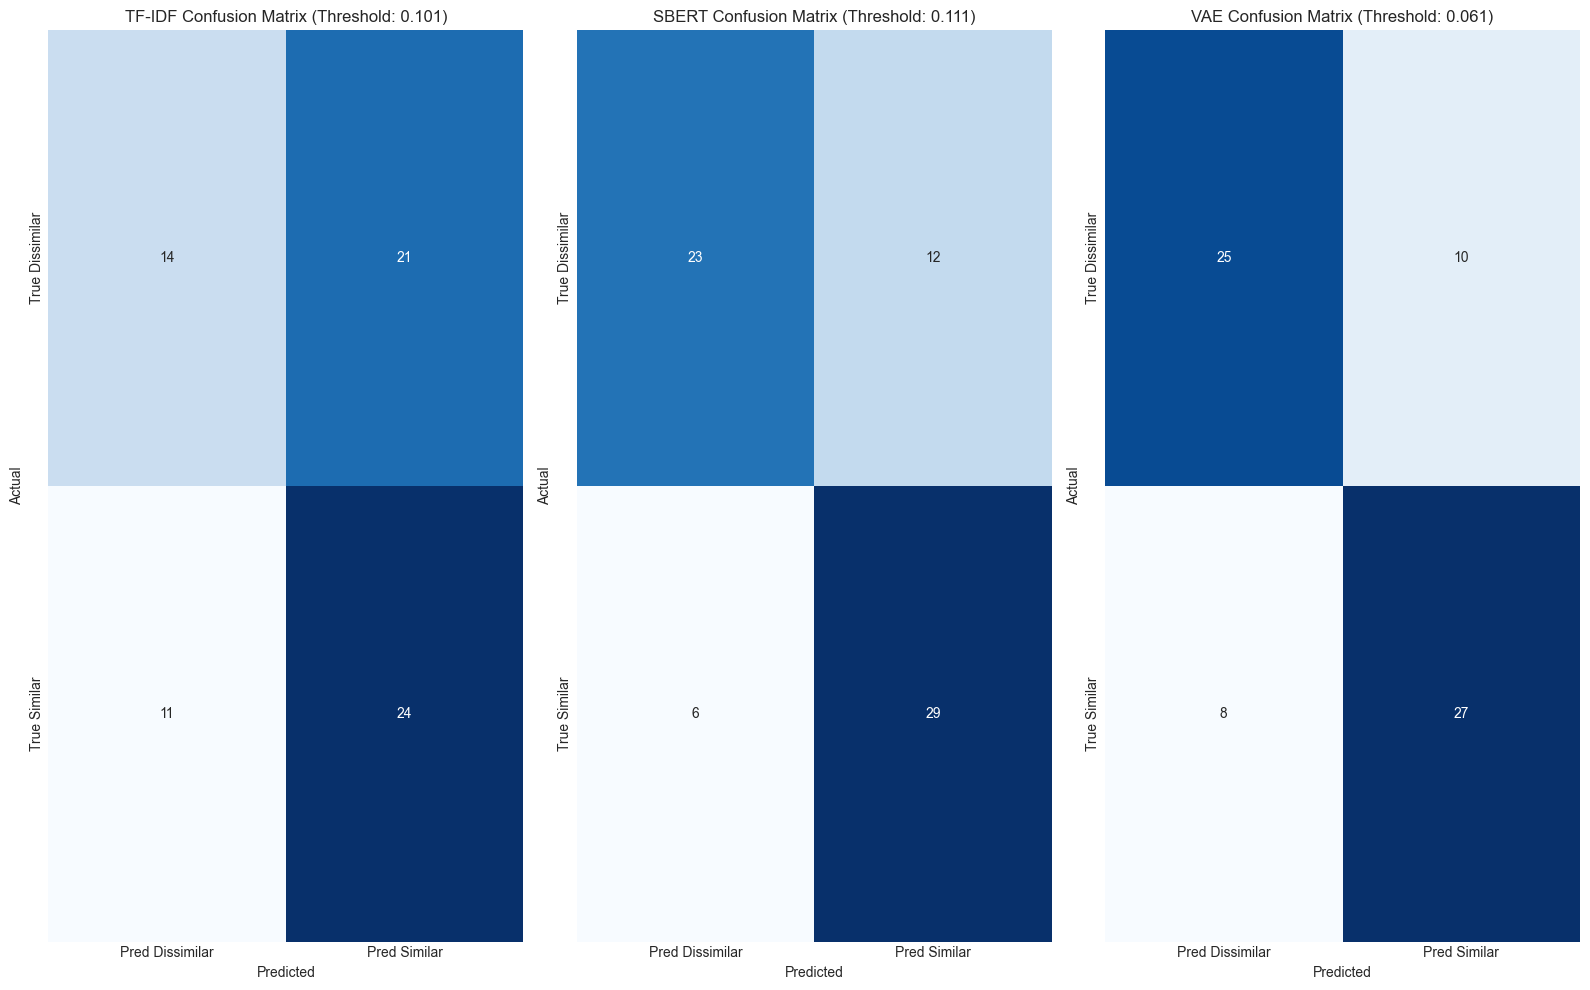

In [59]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

model_results = [
    (results_tfidf, "TF-IDF"),
    (results_sbert, "SBERT"),
    (results_vae, "VAE"),
]

for ax, (results, name) in zip(axes, model_results):
    # Create binary labels and predictions
    y_true = [1] * len(results["pos_sim"]) + [0] * len(results["neg_sim"])
    y_scores = results["pos_sim"] + results["neg_sim"]

    # Find optimal threshold
    best_thresh = max(
        np.linspace(0, 1, 100),
        key=lambda t: sum((s > t) == true for true, s in zip(y_true, y_scores)) / len(y_true),
    )
    y_pred = [1 if s > best_thresh else 0 for s in y_scores]

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
        xticklabels=["Pred Dissimilar", "Pred Similar"],
        yticklabels=["True Dissimilar", "True Similar"],
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{name} Confusion Matrix (Threshold: {best_thresh:.3f})")

    # Calculate metrics
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{name} Classification Metrics:")
    print(f"   Precision: {precision:.2%}")
    print(f"   Recall:    {recall:.2%}")
    print(f"   F1-Score:  {f1:.2%}")

plt.tight_layout()
plt.show()

In our confusion matrices we can see why teh TF-IDF is really not performing so well. We can see that it has a 


For these confusion matrices, I’m looking at precision, recall, and F1 to see whether my models are actually good at calling things “similar era” vs “different era,” not just getting a decent accuracy number.

Precision is the accuracy of positive predictions, which is measured by TP/(TP + FP), where TP is True Positive and FP is False Positive. It tells us, of the positives we predicted, how many were actually positive.

Recall is the accuracy of correctly identified positives, which is measured by TP/ (TP + FN), where FN is False Negative. This tells us, out of all actual positives, how many our model correctly identified as positive.

Accuracy is the number of correct predictions over total predictions.

For TF-IDF, precision is 53.33% and recall is 68.57%, so it’s very scattered it finds a lot of the true similar pairs (decent recall), but it also calls a bunch of dissimilar stuff “similar" this is because of the seperation im guessing. For SBERT, precision jumps to 70.73% and recall to 82.86% (F1 ≈ 76.32%), which is such a boost from both the TF-IDF and my worse model from assignment 1 when it says two entries are similar, it’s usually right, and it also recovers most of the truly similar ones The VAE lands at 72.97% precision and 77.14% recall (F1 = 75.00%), which is basically in the same league as SBERT, it is just slightly more concervative about what it calls similar but it's still good. So, compared to TF-IDF, both SBERT and the VAE are like way better accross all metrics.

Lets use LIME to see which one of VAE and SBERT is actually doing what I want it to do. 


## 7. Interpretability Analysis

While my models achieve good quantitative performance I want to validate that the are actually learning meaningful patters and not just spurious correlations, and so interpretability will answer what features drive predictions and if the influential words are actually relevant like "Taiwan" and "dumplings" and not just random meaningless words. We also get a sneak peak to see if SBERT and VAE learn similar representations. Without this our model might associate random words like "the" and "and" with specific songs. 

LIME (Local Interpretable Model-agnostic Explanations) explains individual predictions by removing random words from the query text and observing how the prediction changes. It fits a linear model and approximates the black box models with a more interpretable model and then checks which words have the biggest impact.

### 7.1 Mathematical Framework

LIME finds an explanation model $\xi(x)$ around a specific input $x$ by solving:

$$
\xi(x) = \arg\min_{g \in G} \mathcal{L}(f, g, \pi_x) + \Omega(g)
$$

where we have that the $f$ is our black box model (SBERT / VAE / TF-IDF) and then $g$ is our interpretable model (e.g., linear regression on word presence) and $\pi_x$ is our weights on perturbations based on how close they are to $x$.


So for a query like **“today I ate dumplings with shin”** it generates perturbations like “today I ate with shin” (removed “dumplings”) or “today I ate dumplings” (removed “with shin”), then it generates predictions like Original → Song A (similarity: 0.75) then Remove “dumplings” → Song B (similarity: 0.45), then it fits the linear model by saying "If removing “dumplings” drops similarity by 0.30 “dumplings” gets a high **positive** weight." Finally it ranks the words by the weights so it could look something like:
   1. “dumplings”: +0.30 (strong positive influence)  
   2. “shin”: +0.05 (weak positive influence)  
   3. “today”: –0.01 (negligible influence)

So lets check if our models capture meaningful words to generate embedings.

In [60]:
class SBERTRecommender:
    """Wrapper for LIME compatibility.

    This class adapts the SBERT model to the probability interface that
    LIME expects: given a list of texts, it returns a probability
    distribution over a fixed set of song classes.
    """

    def __init__(self, model, corpus_texts, corpus_songs):
        """Pre-compute corpus embeddings for efficient similarity lookups.

        Args:
            model: Fine-tuned SBERT SentenceTransformer.
            corpus_texts: List/array of journal texts.
            corpus_songs: List/array of song labels (one per text).
        """
        self.model = model
        self.corpus_embeddings = model.encode(corpus_texts, show_progress_bar=False)
        self.corpus_songs = corpus_songs

    def predict_proba(self, texts):
        """Return probability distribution over songs for each input text.

        LIME will call this with a batch of perturbed texts. We:
        1. Encode each text with SBERT.
        2. Compute cosine similarity to all corpus embeddings.
        3. Aggregate by song (max similarity per song).
        4. Apply softmax over the top-10 songs to get a probability
           distribution per text.
        """
        query_embeddings = self.model.encode(texts, show_progress_bar=False)

        probas = []
        for query_emb in query_embeddings:
            # Compute similarities to all corpus entries
            sims = cos_sim(torch.tensor(query_emb), torch.tensor(self.corpus_embeddings))[0].numpy()

            # Aggregate by song (take max similarity for each song)
            song_scores = {}
            for song, sim in zip(self.corpus_songs, sims):
                if song not in song_scores or sim > song_scores[song]:
                    song_scores[song] = sim

            # Convert to probability distribution over top-10 songs
            top_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)[:10]
            scores = np.array([s[1] for s in top_songs])
            probs = np.exp(scores) / np.sum(np.exp(scores))

            probas.append(probs)

        return np.array(probas)


In [61]:
# LIME-compatible recommenders for different embedding models

class TFIDFRecommender:
    """Wrapper for TF-IDF baseline with a predict_proba interface for LIME."""

    def __init__(self, vectorizer, corpus_texts, corpus_songs):
        self.vectorizer = vectorizer
        # Pre-compute corpus TF-IDF vectors
        self.corpus_embeddings = vectorizer.transform(corpus_texts).toarray()
        self.corpus_songs = corpus_songs

    def predict_proba(self, texts):
        """Return probability distribution over songs for each input text."""
        query_embeddings = self.vectorizer.transform(texts).toarray()

        probas = []
        for query_emb in query_embeddings:
            # Compute similarities to all corpus entries
            sims = cos_sim(
                torch.tensor(query_emb, dtype=torch.float32),
                torch.tensor(self.corpus_embeddings, dtype=torch.float32),
            )[0].numpy()

            # Aggregate by song (take max similarity for each song)
            song_scores = {}
            for song, sim in zip(self.corpus_songs, sims):
                if song not in song_scores or sim > song_scores[song]:
                    song_scores[song] = sim

            # Convert to probability distribution over top-10 songs
            top_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)[:10]
            scores = np.array([s[1] for s in top_songs])
            probs = np.exp(scores) / np.sum(np.exp(scores))
            probas.append(probs)

        return np.array(probas)

class VAERecommender:
    """Wrapper for VAE latent space with predict_proba for LIME."""

    def __init__(self, vae_model, base_encoder, corpus_texts, corpus_songs):
        self.vae = vae_model
        self.base_encoder = base_encoder
        self.corpus_songs = corpus_songs

        self.vae.eval()
        with torch.no_grad():
            corpus_raw = base_encoder.encode(corpus_texts, convert_to_tensor=True)
            self.corpus_embeddings = self.vae.get_latent(corpus_raw).cpu().numpy()

    def predict_proba(self, texts):
        query_raw = self.base_encoder.encode(texts, convert_to_tensor=True)
        self.vae.eval()
        with torch.no_grad():
            query_latent = self.vae.get_latent(query_raw).cpu().numpy()

        probas = []
        for q_emb in query_latent:
            sims = cos_sim(
                torch.tensor(q_emb, dtype=torch.float32),
                torch.tensor(self.corpus_embeddings, dtype=torch.float32),
            )[0].numpy()

            song_scores = {}
            for song, sim in zip(self.corpus_songs, sims):
                if song not in song_scores or sim > song_scores[song]:
                    song_scores[song] = sim

            top_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)[:10]
            scores = np.array([s[1] for s in top_songs])
            probs = np.exp(scores) / np.sum(np.exp(scores))
            probas.append(probs)

        return np.array(probas)

# Shared corpus for all recommenders
all_texts = combined_data["journal_text_cleaned"].values
all_songs = combined_data["song"].values

# SBERT-based wrapper
recommender_sbert = SBERTRecommender(model_sbert, all_texts, all_songs)

# TF-IDF baseline wrapper
recommender_tfidf = TFIDFRecommender(tfidf, all_texts, all_songs)

# VAE wrapper (uses base_sbert + vae latent space)
recommender_vae = VAERecommender(vae, base_sbert, all_texts, all_songs)

print("✅ LIME recommenders initialized (SBERT, TF-IDF, VAE)")

✅ LIME recommenders initialized (SBERT, TF-IDF, VAE)


### 7.2 Explaining Specific Recommendations


In [62]:
# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=[f'Song {i}' for i in range(10)])


In [63]:
# Test queries
test_queries = [
"today i ate dumplings with shin. it was like the good old days when he would write numbers in chinese. we got our fortunes told it was so fun",
"walking alone at night thinking about everything that happened this year. feeling nostalgic and a bit sad",
"coffee shop vibes, working on my assignment, rainy day outside, feeling productive and calm"
]


In [64]:
print("🔍 LIME Explanations for Sample Queries:\n")


🔍 LIME Explanations for Sample Queries:




Query 1: today i ate dumplings with shin. it was like the good old days when he would write numbers in chines...

--- SBERT (Fine-tuned) ---

🎵 Top 3 Recommended Songs:
   1. The Adults Are Talking - The Strokes... (similarity: 0.387)
   2. Headlock - Imogen Heap... (similarity: 0.387)
   3. תיק קטן - סטילה... (similarity: 0.381)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↓ our                  | weight: -0.0012
      ↓ shin                 | weight: -0.0011
      ↑ it                   | weight: +0.0009
      ↑ chinese              | weight: +0.0007
      ↓ we                   | weight: -0.0007
      ↑ fortunes             | weight: +0.0007
      ↑ in                   | weight: +0.0005
      ↑ old                  | weight: +0.0004
      ↑ today                | weight: +0.0002
      ↑ so                   | weight: +0.0002


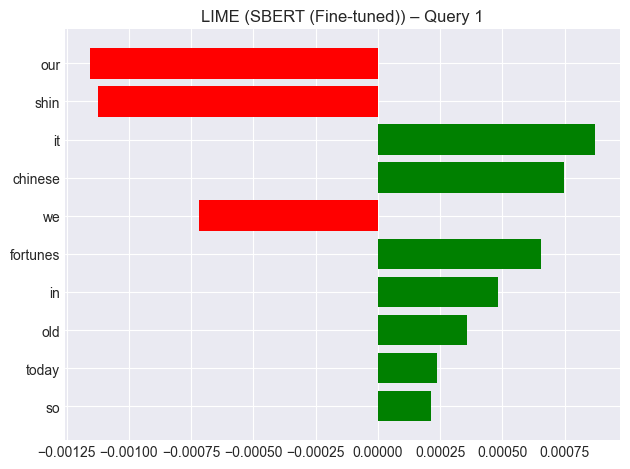


--- TF-IDF Baseline ---

🎵 Top 3 Recommended Songs:
   1. DISRESPECTFUL - Doja Cat... (similarity: 0.195)
   2. Sezen Aksu - Lvbel C5... (similarity: 0.195)
   3. Honeypie - JAWNY... (similarity: 0.195)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↑ numbers              | weight: +0.0011
      ↑ dumplings            | weight: +0.0011
      ↓ was                  | weight: -0.0009
      ↑ chinese              | weight: +0.0008
      ↓ would                | weight: -0.0007
      ↑ in                   | weight: +0.0007
      ↓ we                   | weight: -0.0007
      ↑ days                 | weight: +0.0006
      ↓ fun                  | weight: -0.0005
      ↑ shin                 | weight: +0.0004


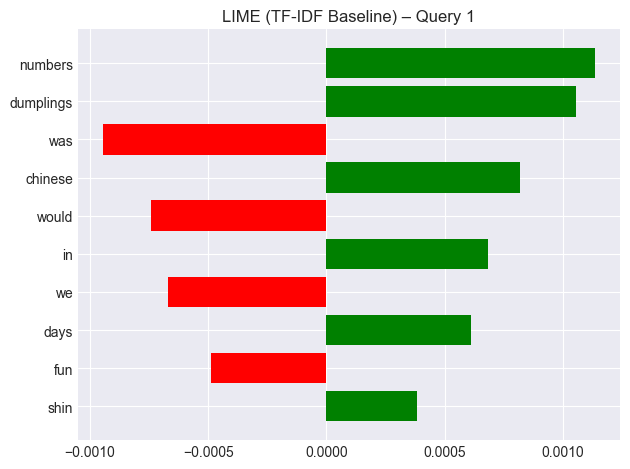


--- VAE ---

🎵 Top 3 Recommended Songs:
   1. Heart To Heart - Mac DeMarco... (similarity: 0.834)
   2. Instant Crush (feat. Julian Casablancas) - Daft Pu... (similarity: 0.732)
   3. Je te laisserai des mots - Patrick Watson... (similarity: 0.732)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↓ he                   | weight: -0.0027
      ↓ we                   | weight: -0.0022
      ↑ numbers              | weight: +0.0018
      ↓ so                   | weight: -0.0016
      ↓ like                 | weight: -0.0015
      ↑ chinese              | weight: +0.0013
      ↑ i                    | weight: +0.0012
      ↑ when                 | weight: +0.0012
      ↑ dumplings            | weight: +0.0012
      ↓ got                  | weight: -0.0005


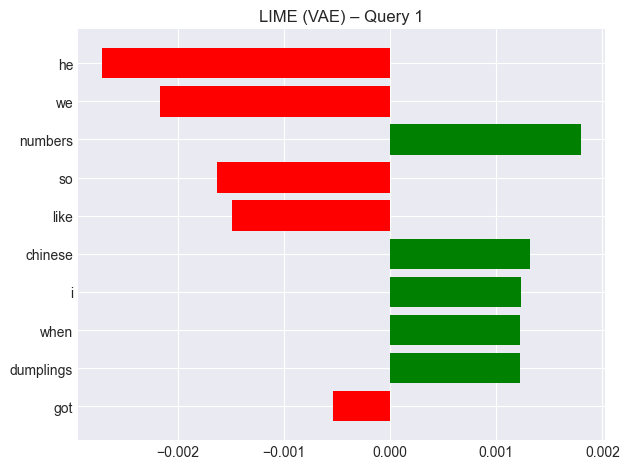


Query 2: walking alone at night thinking about everything that happened this year. feeling nostalgic and a bi...

--- SBERT (Fine-tuned) ---

🎵 Top 3 Recommended Songs:
   1. Instant Crush (feat. Julian Casablancas) - Daft Pu... (similarity: 0.468)
   2. Je te laisserai des mots - Patrick Watson... (similarity: 0.468)
   3. Heart To Heart - Mac DeMarco... (similarity: 0.468)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↓ happened             | weight: -0.0009
      ↑ year                 | weight: +0.0009
      ↓ walking              | weight: -0.0007
      ↑ that                 | weight: +0.0006
      ↑ nostalgic            | weight: +0.0006
      ↑ alone                | weight: +0.0005
      ↓ at                   | weight: -0.0005
      ↓ a                    | weight: -0.0004
      ↓ everything           | weight: -0.0003
      ↑ bit                  | weight: +0.0001


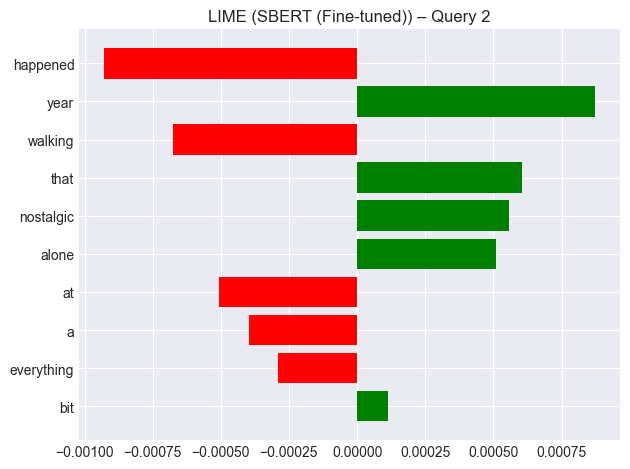


--- TF-IDF Baseline ---

🎵 Top 3 Recommended Songs:
   1. blue - yung kai... (similarity: 0.116)
   2. Hell N Back - Bakar... (similarity: 0.116)
   3. Je te laisserai des mots - Patrick Watson... (similarity: 0.109)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↑ year                 | weight: +0.0008
      ↓ everything           | weight: -0.0005
      ↑ sad                  | weight: +0.0005
      ↓ nostalgic            | weight: -0.0004
      ↓ happened             | weight: -0.0004
      ↑ at                   | weight: +0.0003
      ↑ and                  | weight: +0.0003
      ↓ feeling              | weight: -0.0003
      ↑ this                 | weight: +0.0002
      ↑ thinking             | weight: +0.0001


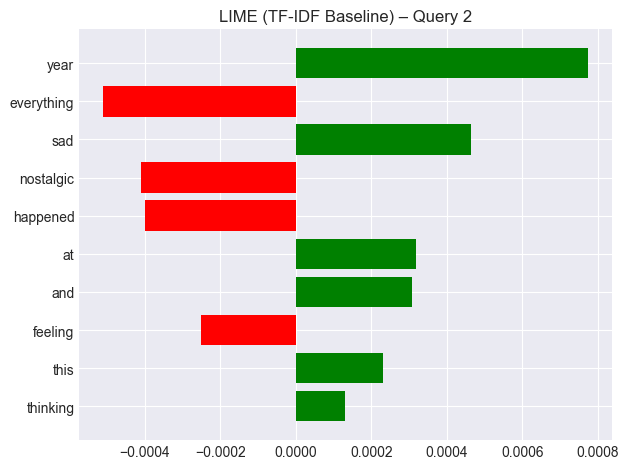


--- VAE ---

🎵 Top 3 Recommended Songs:
   1. Michelle - Remastered 2009 - The Beatles... (similarity: 0.626)
   2. 9am in Calabasas - Adrian... (similarity: 0.609)
   3. Automotivo Portal Ultradimensional - DJ Dudah... (similarity: 0.609)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↓ night                | weight: -0.0014
      ↓ walking              | weight: -0.0011
      ↑ feeling              | weight: +0.0009
      ↓ nostalgic            | weight: -0.0008
      ↑ alone                | weight: +0.0008
      ↑ at                   | weight: +0.0007
      ↓ this                 | weight: -0.0005
      ↓ year                 | weight: -0.0005
      ↓ and                  | weight: -0.0005
      ↑ bit                  | weight: +0.0004


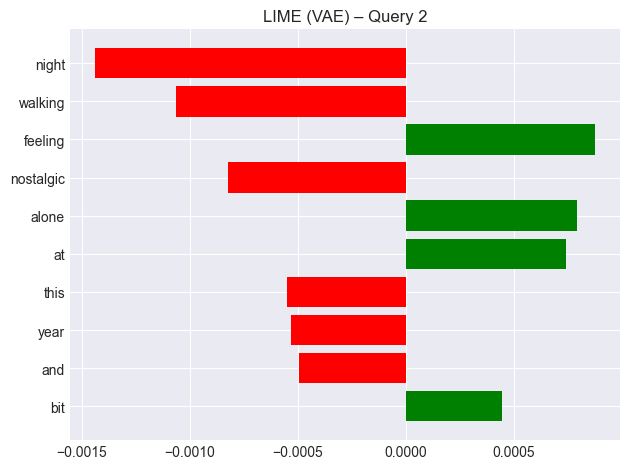


Query 3: coffee shop vibes, working on my assignment, rainy day outside, feeling productive and calm...

--- SBERT (Fine-tuned) ---

🎵 Top 3 Recommended Songs:
   1. Heart To Heart - Mac DeMarco... (similarity: 0.600)
   2. Je te laisserai des mots - Patrick Watson... (similarity: 0.591)
   3. Me quiero ir - lusillón... (similarity: 0.522)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↑ vibes                | weight: +0.0019
      ↑ assignment           | weight: +0.0014
      ↓ feeling              | weight: -0.0012
      ↓ outside              | weight: -0.0011
      ↑ coffee               | weight: +0.0011
      ↑ shop                 | weight: +0.0007
      ↑ on                   | weight: +0.0007
      ↑ and                  | weight: +0.0006
      ↓ productive           | weight: -0.0005
      ↓ rainy                | weight: -0.0003


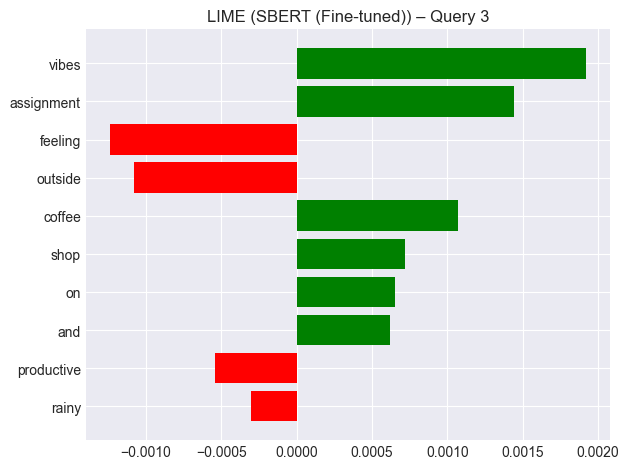


--- TF-IDF Baseline ---

🎵 Top 3 Recommended Songs:
   1. Gasolina - Daddy Yankee... (similarity: 0.133)
   2. In My Mind - Lyn Lapid... (similarity: 0.133)
   3. La Marea - Manu Chao... (similarity: 0.133)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↑ assignment           | weight: +0.0022
      ↓ working              | weight: -0.0012
      ↓ on                   | weight: -0.0007
      ↓ calm                 | weight: -0.0004
      ↓ vibes                | weight: -0.0004
      ↓ shop                 | weight: -0.0003
      ↓ my                   | weight: -0.0003
      ↑ coffee               | weight: +0.0002
      ↓ productive           | weight: -0.0002
      ↑ feeling              | weight: +0.0001


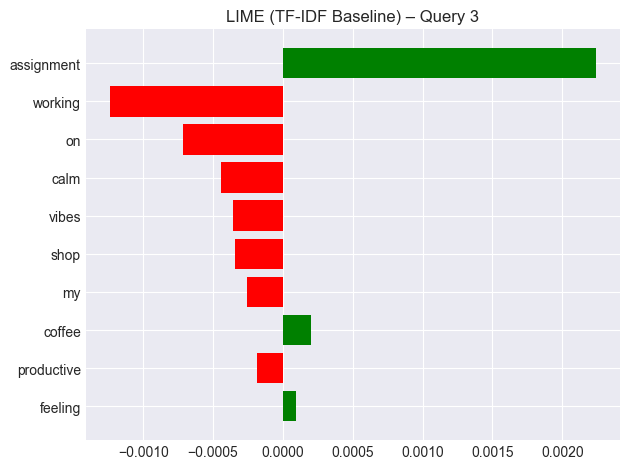


--- VAE ---

🎵 Top 3 Recommended Songs:
   1. Instant Crush (feat. Julian Casablancas) - Daft Pu... (similarity: 0.827)
   2. Je te laisserai des mots - Patrick Watson... (similarity: 0.827)
   3. Heart To Heart - Mac DeMarco... (similarity: 0.827)

📊 LIME Explanation (why #1 was recommended):

   Most influential words:
      ↓ assignment           | weight: -0.0020
      ↑ calm                 | weight: +0.0013
      ↑ working              | weight: +0.0010
      ↑ feeling              | weight: +0.0007
      ↓ coffee               | weight: -0.0007
      ↑ and                  | weight: +0.0006
      ↓ vibes                | weight: -0.0005
      ↓ productive           | weight: -0.0005
      ↓ my                   | weight: -0.0003
      ↓ rainy                | weight: -0.0002


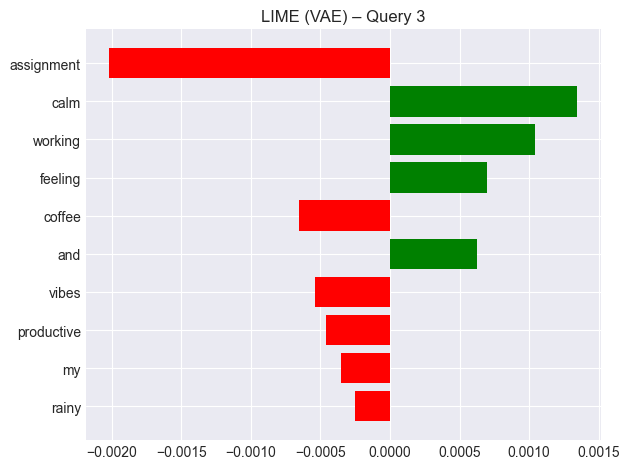

In [65]:
models_for_lime = [
    ("SBERT (Fine-tuned)", recommender_sbert, model_sbert, "sbert"),
    ("TF-IDF Baseline", recommender_tfidf, None, "tfidf"),
    ("VAE", recommender_vae, vae, "vae"),
]

for query_idx, query in enumerate(test_queries):
    print("\n" + "=" * 80)
    print(f"Query {query_idx + 1}: {query[:100]}...")
    print("=" * 80)

    for model_name, rec, backend, kind in models_for_lime:
        print(f"\n--- {model_name} ---")

        # Top-3 recommendations
        if kind == "tfidf":
            # TF-IDF operates directly in TF-IDF space
            query_vec = tfidf.transform([query]).toarray()[0]
            sims = cos_sim(
                torch.tensor(query_vec, dtype=torch.float32),
                torch.tensor(rec.corpus_embeddings, dtype=torch.float32),
            )[0].numpy()
        elif kind == "vae":
            # VAE uses base_sbert encoder + latent space
            query_raw = rec.base_encoder.encode([query], convert_to_tensor=True)
            rec.vae.eval()
            with torch.no_grad():
                query_latent = rec.vae.get_latent(query_raw).cpu().numpy()
            sims = cos_sim(
                torch.tensor(query_latent, dtype=torch.float32),
                torch.tensor(rec.corpus_embeddings, dtype=torch.float32),
            )[0].numpy()
        else:
            # SBERT / SimCSE use their own encoders
            query_emb = backend.encode([query])
            sims = cos_sim(
                torch.tensor(query_emb),
                torch.tensor(rec.corpus_embeddings),
            )[0].numpy()

        song_scores = {}
        for song, sim in zip(all_songs, sims):
            if song not in song_scores or sim > song_scores[song]:
                song_scores[song] = sim

        top_3_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)[:3]

        print("\n🎵 Top 3 Recommended Songs:")
        for rank, (song, score) in enumerate(top_3_songs, 1):
            print(f"   {rank}. {song[:50]}... (similarity: {score:.3f})")

        # LIME explanation for top prediction
        print("\n📊 LIME Explanation (why #1 was recommended):")
        exp = explainer.explain_instance(
            query,
            rec.predict_proba,
            num_features=10,
            num_samples=100,
        )

        word_importances = exp.as_list()

        print("\n   Most influential words:")
        for word, weight in sorted(word_importances, key=lambda x: abs(x[1]), reverse=True)[:10]:
            direction = "↑" if weight > 0 else "↓"
            print(f"      {direction} {word:20s} | weight: {weight:+.4f}")

        fig = exp.as_pyplot_figure()
        plt.title(f"LIME ({model_name}) – Query {query_idx + 1}")
        plt.tight_layout()
        plt.show()



#### 7.2.1 Query 1: "today i ate dumplings with shin. it was like the good old days when he would write numbers in chinese…"

**SBERT**  
Top recommendation: *The Adults Are Talking – The Strokes*  
Most influential words (LIME) are a weird mix of tiny function words and a few content words: positive weights on **“it”**, **“chinese”**, **“fortunes”**, **“in”**, **“old”**, **“today”**, **“so”** and negative weights on **“our”**, **“shin”**, and **“we”**, so what is happening is that it is capturing the general vibe and era of “old chinese fortunes” rather than my boyfriend and the fact that “shin” and “our/we” are negative suggests it's not really relating them to this era specifically. This makes sense, as I did not necessarily get my fortune told with shin in Taiwan but with my other firends so maybe it is seperating them. The absence of “dumplings” as a strong positive is weird though I thought it would latch onto this. This song overlaps based on explanatory data. 

**VAE**  
Top recommendation: *Heart To Heart – Mac DeMarco*  
The VAE gives strong positive weight to **“numbers”**, **“chinese”**, **“i”**, **“when”**, and **“dumplings”**, and negative weight to **“he”**, **“we”**, **“so”**, **“like”**, and **“got”**. So unlike SBERT, it very much cares about my dumpling/Chinese numerology combo and downweights generic social pronouns...which is better I feal as I was usual doing both at the same time, it suggests that the VAE might be outperforming BERT in terms of capturing my nostalgia. Also *Heart To Heart – Mac DeMarco* I personally feel captures it better, and looking at our explanatory data from earlier it overlaps better as well. 

#### 7.2.2 Query 2: "walking alone at night thinking about everything that happened this year. feeling nostalgic and a bit sad…"

**SBERT**  
Top recommendation: *Instant Crush – Daft Punk*  
Positive words are **“year”**, **“that”**, **“nostalgic”**, **“alone”**, **“bit”**, while **“happened”**, **“walking”**, **“at”**, **“a”**, and **“everything”** get negative weight. SBERT is doing exactly what I want here it focuses on the emotional/time‑anchoring pieces (“nostalgic”, “alone”, “year”) and basically ignores the more irrelavant stuff but I thought it would anchor more on the **"sad"**, also *Instant Crush – Daft Punk* is my night lonely song so this matches well.

**VAE**  
Top recommendation: *Michelle – The Beatles*
The VAE likes **“feeling”**, **“alone”**, **“at”**, **“bit”**, and gives negative weight to **“night”**, **“walking”**, **“nostalgic”**, **“this”**, **“year”**, and **“and”**. This is pretty bad as it should be capturing more of what the SBERT was capturing... also *Michelle – The Beatles* is not a song that fits this context.

#### 7.2.3 Query 3: "coffee shop vibes, working on my assignment, rainy day outside, feeling productive and calm…"

**SBERT**  
Top recommendation: *Heart To Heart – Mac DeMarco*  
SBERT gives big positive weight to **“vibes”**, **“assignment”**, **“coffee”**, **“shop”**, **“on”**, **“and”**, and negative weight to **“feeling”**, **“outside”**, **“productive”**, and **“rainy”**. This means the SBERT it capturing the coffee shop study era vibes which is exactly what i want it to do, and so when I am studying it will take me to this era which is so cool! Also *Heart To Heart – Mac DeMarco* is one of those songs that overlap with pretty much everything based on explanatory data so it fits here, I study and listen to this song a lot.

**VAE**  
Top recommendation: *Instant Crush – Daft Punk* 
It gives positive weight to **“calm”**, **“working”**, **“feeling”**, **“and”**, and negative weight to **“assignment”**, **“coffee”**, **“vibes”**, **“productive”**, **“my”**, and **“rainy”**. This is fine I guess but it's not really touching on the "coffee shop and study vibes" the way I would want it to, it is more anchoring in on my calmness while working. This also works, just in a different way and the song matches too. However, I think I am more into coffee shop and assignment study then the whole calm work vibe, but this is just a preferance. That being said I AM THE USER and so I just naturally choose what works best for me and that is the SBERT.

#### 7.2.1 Opinions

So what I observe is that both the SBERT and VAE kind of create different eras and match them so one might do like coffee shop + study and another might do work + calm for the same sequence, which I guess works. I personally resonate based on the Real World Performance with the SBERT model in terms of the songs and the era it captures.

### 7.3 Real World Results

In [69]:
def recommend_songs_with_all_models(query, top_k=5):
    print("\n" + "=" * 100)
    print(f"🎯 Query: {query}")
    print("=" * 100 + "\n")

    models = [
        ("SBERT (Fine-tuned)", "sbert"),
        ("TF-IDF Baseline", "tfidf"),
        ("VAE (Latent Space)", "vae"),
    ]

    for model_name, kind in models:
        print(f"\n--- {model_name} ---")

        if kind == "sbert":
            encoder = model_sbert
            corpus_emb = encoder.encode(unique_texts)
            query_emb = encoder.encode([query])
            sims = cos_sim(
                torch.tensor(query_emb),
                torch.tensor(corpus_emb),
            )[0].numpy()

        elif kind == "tfidf":
            corpus_emb = tfidf.transform(unique_texts).toarray()
            query_vec = tfidf.transform([query]).toarray()[0]
            sims = cos_sim(
                torch.tensor(query_vec, dtype=torch.float32),
                torch.tensor(corpus_emb, dtype=torch.float32),
            )[0].numpy()

        elif kind == "vae":
            base_encoder = base_sbert  # already loaded for VAE
            vae.eval()
            with torch.no_grad():
                query_raw = base_encoder.encode([query], convert_to_tensor=True)
                query_latent = vae.get_latent(query_raw).cpu().numpy()
                corpus_raw = base_encoder.encode(unique_texts, convert_to_tensor=True)
                corpus_emb = vae.get_latent(corpus_raw).cpu().numpy()
            sims = cos_sim(
                torch.tensor(query_latent, dtype=torch.float32),
                torch.tensor(corpus_emb, dtype=torch.float32),
            )[0].numpy()

        else:
            continue

        # Map similarities back to songs
        song_scores = {}
        for text, sim in zip(unique_texts, sims):
            songs = combined_data[combined_data["journal_text_cleaned"] == text]["song"].unique()
            for song in songs:
                if song not in song_scores or sim > song_scores[song]:
                    song_scores[song] = sim

        top_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

        for rank, (song, score) in enumerate(top_songs, 1):
            dates = combined_data[combined_data["song"] == song]["date"].unique()
            date_str = f"{min(dates)} to {max(dates)}" if len(dates) > 1 else str(dates[0])
            plays = combined_data[combined_data["song"] == song]["play_count"].sum()

            print(f"   {rank}. {song[:60]}")
            print(f"      Similarity: {score:.4f} | Period: {date_str} | Total plays: {plays}")

    # Optional: overlap analysis between SBERT and VAE
    print("\n📊 Model Agreement (SBERT vs VAE):")
    # Recompute top_k for SBERT and VAE to compare sets
    encoder = model_sbert
    corpus_emb_sbert = encoder.encode(unique_texts)
    query_emb_sbert = encoder.encode([query])
    sims_sbert = cos_sim(torch.tensor(query_emb_sbert), torch.tensor(corpus_emb_sbert))[0].numpy()
    song_scores_sbert = {}
    for text, sim in zip(unique_texts, sims_sbert):
        songs = combined_data[combined_data["journal_text_cleaned"] == text]["song"].unique()
        for song in songs:
            if song not in song_scores_sbert or sim > song_scores_sbert[song]:
                song_scores_sbert[song] = sim
    top_sbert = sorted(song_scores_sbert.items(), key=lambda x: x[1], reverse=True)[:top_k]

    base_encoder = base_sbert
    vae.eval()
    with torch.no_grad():
        query_raw = base_encoder.encode([query], convert_to_tensor=True)
        query_latent = vae.get_latent(query_raw).cpu().numpy()
        corpus_raw = base_encoder.encode(unique_texts, convert_to_tensor=True)
        corpus_emb_vae = vae.get_latent(corpus_raw).cpu().numpy()
    sims_vae = cos_sim(
        torch.tensor(query_latent, dtype=torch.float32),
        torch.tensor(corpus_emb_vae, dtype=torch.float32),
    )[0].numpy()
    song_scores_vae = {}
    for text, sim in zip(unique_texts, sims_vae):
        songs = combined_data[combined_data["journal_text_cleaned"] == text]["song"].unique()
        for song in songs:
            if song not in song_scores_vae or sim > song_scores_vae[song]:
                song_scores_vae[song] = sim
    top_vae = sorted(song_scores_vae.items(), key=lambda x: x[1], reverse=True)[:top_k]

    sbert_songs = {s[0] for s in top_sbert}
    vae_songs = {s[0] for s in top_vae}
    overlap = sbert_songs & vae_songs

    print(f"   {len(overlap)}/{top_k} songs in common")
    if overlap:
        print(f"   Shared recommendations: {', '.join([s[:30] for s in overlap])}")


In [70]:
# Test queries
test_queries_final = [
"today i ate dumplings with shin. we talked about the old days and got our fortunes told",
"rainy day alone at home feeling nostalgic and introspective",
"late night bus ride thinking about everything that changed this year",
"hiking with friends beautiful weather feeling alive and present",
]


In [73]:
for query in test_queries_final:
    recommend_songs_with_all_models(query, top_k=1)


🎯 Query: today i ate dumplings with shin. we talked about the old days and got our fortunes told


--- SBERT (Fine-tuned) ---
   1. Hell N Back - Bakar
      Similarity: 0.4309 | Period: 2024-04-16 to 2025-05-28 | Total plays: 94

--- TF-IDF Baseline ---
   1. Tamacun - Rodrigo y Gabriela
      Similarity: 0.1266 | Period: 2024-09-22 to 2024-12-09 | Total plays: 26

--- VAE (Latent Space) ---
   1. Killshot - Magdalena Bay
      Similarity: 0.8031 | Period: 2025-02-22 to 2025-02-24 | Total plays: 15

📊 Model Agreement (SBERT vs VAE):
   0/1 songs in common

🎯 Query: rainy day alone at home feeling nostalgic and introspective


--- SBERT (Fine-tuned) ---
   1. Instant Crush (feat. Julian Casablancas) - Daft Punk
      Similarity: 0.6413 | Period: 2024-03-05 to 2024-12-31 | Total plays: 21

--- TF-IDF Baseline ---
   1. Je te laisserai des mots - Patrick Watson
      Similarity: 0.1224 | Period: 2024-03-06 to 2024-12-31 | Total plays: 80

--- VAE (Latent Space) ---
   1. Instant Crush (

We can see that the SBERT and VAE sometimes have overlap like 25%, which is pretty low. Like this might be expected though as several songs share the same journal entries and span the same space so it just depends on how you actually define nostalgia and what is nostalgic to you. For me, I resonate the most with the VAE despite me resonating more with the way the SBERT actually defines an era of a song. I think this is because the VAE is more certain than the SBERT, as you can see the similarity scores are bigger, and this might be because it has a way greater seperation than the SBERT model. So I would definetly choose VAE over SBERT. 

None the less both models work well for my purpose... so hey man why not listen to more music man?

## Latent Space Visualization (VAE)

Computing t-SNE projection...


python(21911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


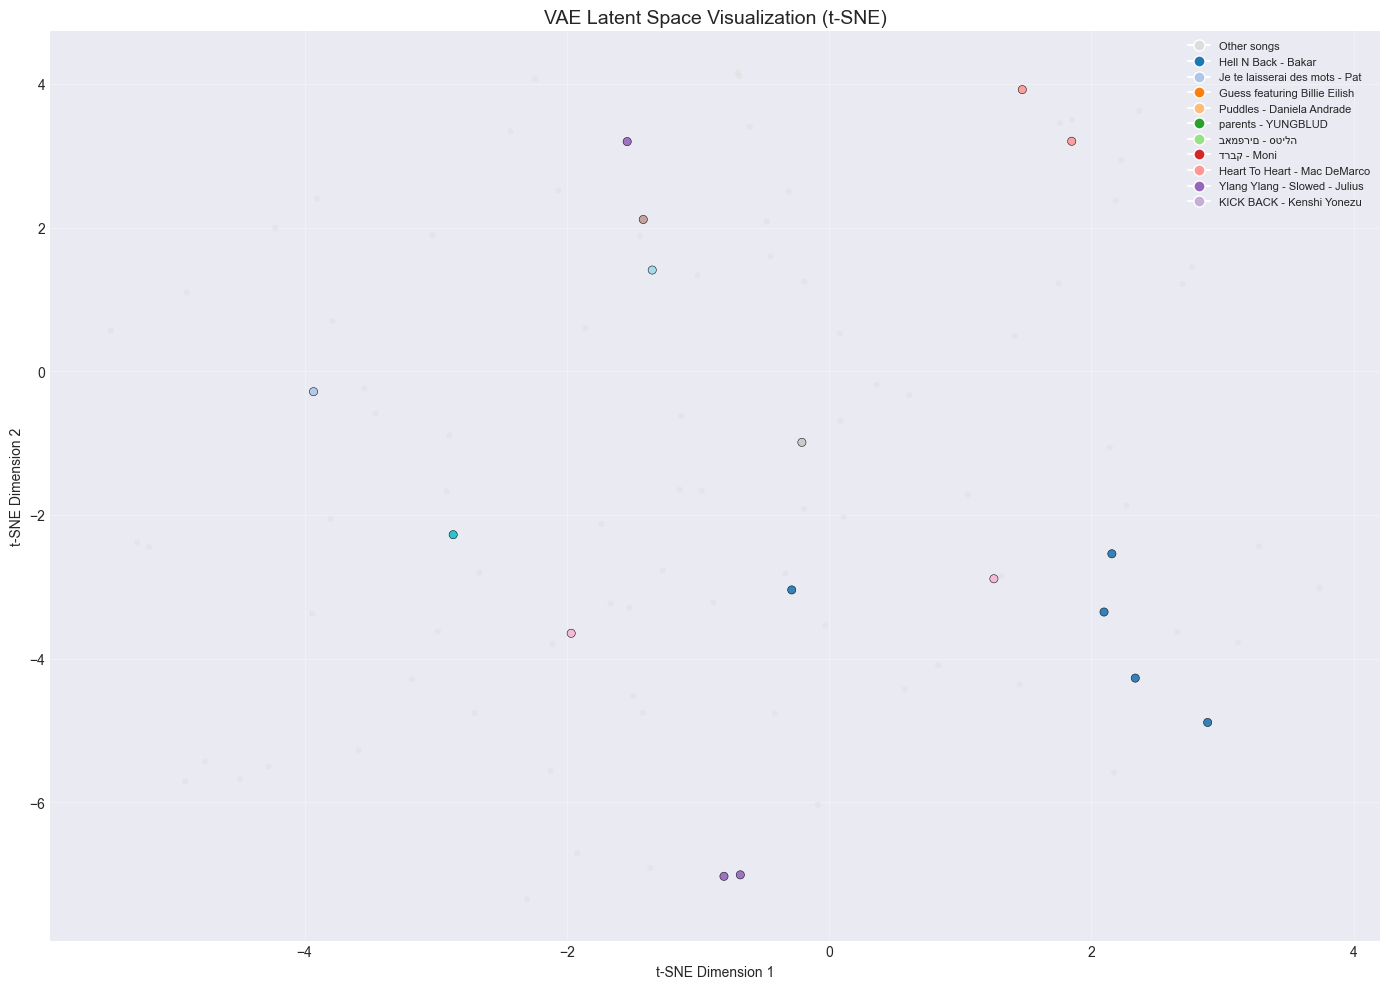

✅ Latent space visualization complete
   Colored songs: 20 with ≥5 plays


In [72]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Get VAE latent embeddings for all data
base_encoder = SentenceTransformer("sentence-transformers/all-distilroberta-v1", device="cpu")
all_embeddings_raw = base_encoder.encode(unique_texts, convert_to_tensor=True)  # Limit for visualization
vae.eval()
with torch.no_grad():
    latent_embeddings = vae.get_latent(all_embeddings_raw).cpu().numpy()

# Map each text to its song
songs_for_viz = []
for text in unique_texts:
    song = combined_data[combined_data["journal_text_cleaned"] == text]["song"].iloc[0]
    songs_for_viz.append(song)

# ========= choose which songs get their own color =========
min_plays_for_color = 5       # ↓ lower this (e.g. 3 or 1) to color more songs
max_colored_songs = 20        # ↑ raise this (e.g. 30) if you want even more colors

popular_songs = plays_per_song[plays_per_song >= min_plays_for_color].head(max_colored_songs).index
song_to_color = {song: i for i, song in enumerate(popular_songs)}

is_popular = np.array([s in song_to_color for s in songs_for_viz])
popular_idx = np.where(is_popular)[0]
other_idx = np.where(~is_popular)[0]

popular_colors = [song_to_color[songs_for_viz[i]] for i in popular_idx]

# ========= t-SNE projection =========
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(14, 10))

# Other songs in light grey
plt.scatter(
    latent_2d[other_idx, 0],
    latent_2d[other_idx, 1],
    c="#DDDDDD",
    alpha=0.4,
    s=20,
    edgecolors="none",
    label="Other songs",
)

# Popular songs colored
plt.scatter(
    latent_2d[popular_idx, 0],
    latent_2d[popular_idx, 1],
    c=popular_colors,
    cmap="tab20",
    alpha=0.9,
    s=35,
    edgecolors="black",
    linewidth=0.4,
)

# Legend: first "Other songs", then the first ~10 popular songs
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w",
        markerfacecolor="#DDDDDD", markersize=8, label="Other songs",
    )
]
for song in list(popular_songs)[:10]:
    handles.append(
        plt.Line2D(
            [0], [0], marker="o", color="w",
            markerfacecolor=plt.cm.tab20(song_to_color[song] / 20),
            markersize=8, label=song[:30],
        )
    )

plt.legend(handles=handles, loc="upper right", fontsize=8, framealpha=0.9)
plt.title("VAE Latent Space Visualization (t-SNE)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Latent space visualization complete")
print(f"   Colored songs: {len(popular_songs)} with ≥{min_plays_for_color} plays")

# 9. References

## Direct Copying

From Assignment 1 I copied my SBERT model almost entirely just edited quite a few of the parameters and structure. Additionally the dtaa pre processing the data exploration etc... was all copied from Assignment 1 as well. A lot of the explanations were also directly copied from Assignment 1, I did substantially edit them to improve clarity though.

## Academic Papers
1. Devlin, J., et al. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. NAACL. https://arxiv.org/abs/1810.04805
2. Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. EMNLP. https://arxiv.org/abs/1908.10084
3. Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. ICLR. https://arxiv.org/abs/1312.6114
4. Ribeiro, M. T., et al. (2016). "Why Should I Trust You?": Explaining the Predictions of Any Classifier. KDD. https://arxiv.org/abs/1602.04938
5. Liu, Y., et al. (2019). RoBERTa: A Robustly Optimized BERT Pretraining Approach. https://arxiv.org/abs/1907.11692

## Documentation & Tutorials
1. Sentence Transformers Documentation: https://www.sbert.net/
2. HuggingFace Transformers: https://huggingface.co/docs/transformers/
3. PyTorch VAE Tutorial: https://github.com/pytorch/examples/tree/master/vae
4. LIME Documentation: https://github.com/marcotcr/lime
5. Scikit-learn Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

## AI Statement

AI Statement:
1. I used chatgpt to correct my grammar in the markdowns.
2. I used claude to help me refine graphs and my confusion matrix and to help write my evaluation models like MRR. I love AI for graphs and redundant tasks <3
3. I used AI to help with A LOT OF BUGS, and sometimes to help with understanding what I can do better for model training. 

Also note that I use "✅" this is something that I guess counts sometimes as a red flag, but I personally adopted this from AI as I like seeing a big green check when my code runs well! This is stylistic choice not AI!
(^this statement is copied from previous assignment)
